## Scripts to create runoff plots for different (selected) basins 

In [1]:
# updated script version for flattening gfdl-esm2m overshoot stabilisation scenarios from university of Bern 
from oggm import utils
import json
import oggm
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.linear_model import LinearRegression
import geopandas as gpd

# get the correct colors for the different scenarios
from analysis_func import (color_scenario, label_scenario, provide_reg_full_name_dict, color_scenario_poster, scenario_ls,
                           find_largest_continuous_span,get_basin_trough_water_stats)
palette = sns.color_palette(color_scenario.values())

In [2]:
plt.rcParams['figure.dpi'] = 72  # Lower DPI for smaller file size of the notebook

In [5]:
bc = 'bc_1980_2019'
df_scenario_common_basin = xr.open_dataset(f'../data/common_running_sum_all_basins_oversh_stab_2000_2500_{bc}.nc').sel(bias_correction=bc)
pd_basin_num = gpd.read_file('/home/www/fmaussion/misc/magicc/basins_shape/glacier_basins.shp')
f = open('/home/www/lschuster/provide/provide_glacier_regions/basin_ids_per_provide_region.json')
basins_per_preg = json.load(f)

df_scenario_common_basin['runoff_51_yr_avg'] = df_scenario_common_basin.runoff.isel(time=slice(0,-1)).rolling(min_periods=51, time=51, center=True).mean()
df_scenario_common_basin['runoff_21_yr_min'] = df_scenario_common_basin.runoff.isel(time=slice(0,-1)).rolling(min_periods=21, time=21, center=True).min()
df_scenario_common_basin['runoff_m_51_yr_avg'] = df_scenario_common_basin.runoff_monthly.isel(time=slice(0,-1)).rolling(min_periods=51, time=51, center=True).mean()
df_scenario_common_basin['melt_off_on_51_yr_avg'] = df_scenario_common_basin.melt_off_on.isel(time=slice(0,-1)).rolling(min_periods=51,
                                                                                                                        time=51, center=True).mean()

pd_runoff_scenario_rel_basin = (100*df_scenario_common_basin.runoff_51_yr_avg/df_scenario_common_basin.sel(time=2025).runoff_51_yr_avg).to_dataframe('runoff_rel_2000_2050_%').reset_index()
pd_melt_off_on_scenario_rel_basin = (100*df_scenario_common_basin.melt_off_on_51_yr_avg/df_scenario_common_basin.sel(time=2025).melt_off_on_51_yr_avg).to_dataframe('melt_off_on_rel_2000_2050_%').reset_index()
pd_runoff_scenario_rel_basin_21_yr_min = (100*df_scenario_common_basin.runoff_21_yr_min/df_scenario_common_basin.sel(time=2010).runoff_21_yr_min).to_dataframe('runoff_min_rel_2000_2020_%').reset_index()
assert np.all(df_scenario_common_basin.runoff.sel(time=slice(2000,2020)).min(dim='time') == df_scenario_common_basin.sel(time=2010).runoff_21_yr_min)


In [6]:
scenarios = ['stab_T15', 'stab_T30', 'oversh_T30OS15']
list_color_scenario_poster_new_order = [color_scenario_poster[scenarios[0]],
                                        color_scenario_poster[scenarios[1]],
                                        color_scenario_poster[scenarios[2]]]                                               

**Some overall statistics on all basins with some glaciation**

In [7]:
len(pd_basin_num)

75

In [8]:
pd_basin_num.CONTINENT.unique()

array(['Asia', 'South America',
       'North America, Central America and the Caribbean',
       'South-West Pacific', 'Europe'], dtype=object)

In [9]:
len(pd_basin_num.loc[(pd_basin_num.RGI_AREA>30)&(100*pd_basin_num.RGI_AREA/pd_basin_num.AREA_CALC>0.01)])

75

In [10]:
len(pd_basin_num.loc[(pd_basin_num.RGI_AREA>30)&(100*pd_basin_num.RGI_AREA/pd_basin_num.AREA_CALC>0.01)& (pd_basin_num.AREA_CALC>50000)])

39

In [11]:
len(pd_basin_num.loc[(pd_basin_num.RGI_AREA>30)&(100*pd_basin_num.RGI_AREA/pd_basin_num.AREA_CALC>0.01)& (pd_basin_num.AREA_CALC>5000)])

72

In [12]:
100*(pd_basin_num.RGI_AREA/pd_basin_num.AREA_CALC).min()

0.011259669461938704

**compute some statistics for every basin**

In [13]:
# some basin climate data
pd_clim_all = pd.read_csv('../data/annual_glob_rgi_reg_basin_temp_precip_timeseries_oversh_stab.csv', index_col = 'Unnamed: 0')
pd_clim_all['precip_51yr_avg'] = pd_clim_all['precip'].rolling(51,center=True, min_periods=51).mean()

In [14]:
# get drought buffering index of the basins
## from Ultee et al.,  2022, Glacial runoff buffers droughts through the 21st century  (their table A1) --> see: https://doi.org/10.5194/esd-13-935-2022
basin_names = ['INDUS','TARIM','BRAHMAPUTRA','ARAL SEA','COPPER','GANGES','YUKON','ALSEK','SUSITNA','BALKHASH','STIKINE','SANTA CRUZ',
'FRASER','BAKER','YANGTZE','SALWEEN','COLUMBIA','ISSYK-KUL','AMAZON','COLORADO','TAKU','MACKENZIE','NASS','THJORSA','JOEKULSA A F.',
'KUSKOKWIM','RHONE','SKEENA','OB','OELFUSA','MEKONG','DANUBE','NELSON RIVER','PO','KAMCHATKA','RHINE','GLOMA','HUANG HE','INDIGIRKA',
'LULE','RAPEL','SANTA','SKAGIT','KUBAN','TITICACA','NUSHAGAK','BIOBIO','IRRAWADDY','NEGRO','MAJES','CLUTHA','DAULE-VINCES',
'KALIXAELVEN','MAGDALENA','DRAMSELV','COLVILLE']

basin_glacier_area_km2 = [26893.8, 24645.4, 16606.7, 15176.7, 12998., 11216., 9535.4, 5614.8, 4304., 
3945.4, 3467.6, 3027.8, 2495.1, 2372.3, 2317.4, 2295.9, 1878.4, 1677.3,
1634.1, 1601.2, 1583.6, 1519.2, 1337.3, 1251.8, 1098.6, 1032.8, 904.2, 742.3,
739.5, 683.4, 485.7, 408.4, 374.7, 347.3, 312.7, 285.0, 269.4, 267.9, 248.4,
247.2, 238.1, 198.9, 159.5, 146., 134.5, 86.4, 76.2, 71.2, 64.1, 57.3, 46.5, 
40.6, 37.9, 33.3, 32.1, 31.9]


BasinArea=[1139075,1051731,518011,1233148,64959,1024462,829632,28422,49470,423657,51147,30599,
239678,30760,1745094,258475,668561,191032,5880854,390631,17967,1752001,21211,7527,7311,
118114,97485,42944,2701040,5678,787256,793704,1099380,73066,54103,190522,42862,988062,341227,
25127,15689,11882,7961,58935,107215,29513,24108,411516,130062,18612,17118,41993,
17157,261204,17364,57544] # area of each basin in km2

# Aridity index is a multi-GCM mean over the 1980–2010 historical period
aridity_index = [
    0.54, 0.64, 2.70, 0.45, 8.98, 0.78, 2.95, 8.46, 5.54, 0.55,
    6.18, 3.47, 2.72, 4.00, 1.79, 1.80, 1.54, 0.55, 1.14, 0.56,
    6.10, 1.50, 6.02, 6.70, 8.23, 3.86, 1.90, 4.66, 1.13, 4.85,
    1.37, 1.25, 0.91, 1.57, 3.47, 2.09, 3.62, 1.15, 1.88, 3.56,
    0.67, 1.50, 2.36, 0.96, 1.91, 4.28, 1.15, 1.66, 0.96, 1.34,
    3.07, 3.02, 2.75, 1.80, 4.00, 2.66
] # precipitation vs PET (higher values indicate wetter conditions !!!

pd_basins = pd.DataFrame(index=basin_names, columns=['basin_glacier_area_km2_ultee_2022', 'basin_total_area_km2_ultee_2022', 'aridity_index_ultee_2022'])
pd_basins['basin_glacier_area_km2_ultee_2022'] = basin_glacier_area_km2
pd_basins['basin_total_area_km2_ultee_2022'] = BasinArea
pd_basins['aridity_index_ultee_2022'] = aridity_index
pd_basins['glaciated_perc_ultee_2022'] = 100*pd_basins['basin_glacier_area_km2_ultee_2022'] / pd_basins['basin_total_area_km2_ultee_2022']
pd_basin_num['glaciated_vs_basin_area_RGI6_perc'] = 100*pd_basin_num['RGI_AREA']/pd_basin_num['AREA_CALC']

for _lb in pd_basins.index.values:
    if _lb not in pd_basin_num.RIVER_BASI.values:
        if _lb == 'AMAZON':
            b = 'AMAZON (also AMAZONAS)'
        elif _lb == 'JOEKULSA A F.':
            b = 'JOKULSA A FJOLLUM'
        elif _lb == 'ISSYK-KUL':
            b = 'YSYK-KOL (also ISSYK-KUL)'
        elif _lb == 'BALKHASH':
            b = 'LAKE BALKHASH'
        elif _lb == 'TARIM':
            b = 'TARIM HE (also TALIMU HE)'
        elif _lb == 'OELFUSA':
            b = 'OLFUSA'
        elif _lb == 'NELSON RIVER':
            b = 'NELSON'
        elif _lb == 'GLOMA':
            b = 'GLOMAA'
        elif _lb == 'HUANG HE':
            b = 'YELLOW RIVER'
        elif _lb == 'LULE':
            b = 'LULEALVEN'
        elif _lb == 'NEGRO':
            b = 'NEGRO (Atlantic Ocean)'
        elif _lb == 'DAULE-VINCES':
            print(f'{_lb} is probably in Ecuador but could not be found in the OGGM basin file names ... according to Ultee (2022), not enough glaciated anyways ... ')
        elif _lb == 'KALIXAELVEN':
            b = 'KALIXALVEN'
        elif _lb == 'DRAMSELV':
            b = 'DRAMSELVA'
        else:
            # ok we could rename all except for DAULE-VINCES
            print(_lb)
    else:
        b = _lb
    pd_basin_num.loc[pd_basin_num.RIVER_BASI == b, 'aridity_index_ultee_2022'] = pd_basins.loc[_lb, 'aridity_index_ultee_2022']
pd_basin_num.index = pd_basin_num['RIVER_BASI']

DAULE-VINCES is probably in Ecuador but could not be found in the OGGM basin file names ... according to Ultee (2022), not enough glaciated anyways ... 


In [15]:
pd_basin_num_glac = pd_basin_num.loc[(pd_basin_num.glaciated_vs_basin_area_RGI6_perc>0.1)]
pd_basin_num_glac.AREA_CALC.max()

1563201.7

In [16]:
pd_basin_num_glac.sort_values(by='AREA_CALC')

MRBID                 RIVER_BASI  \
RIVER_BASI                                                    
LAGARFLJOT                  6104                 LAGARFLJOT   
AZOPARDO                    3403                   AZOPARDO   
SVARTA                      6110                     SVARTA   
CISNES                      3408                     CISNES   
OLFUSA                      6237                     OLFUSA   
JOKULSA A FJOLLUM           6101          JOKULSA A FJOLLUM   
SKAGIT                      4426                     SKAGIT   
THJORSA                     6254                    THJORSA   
SERRANO                     3426                    SERRANO   
PUELO                       3422                      PUELO   
HUASCO                      3412                     HUASCO   
VALDIVIA                    3428                   VALDIVIA   
YELCHO                      3429                     YELCHO   
SANTA                       3425                      SANTA   
AISEN                       3401                      AISEN   
PALENA (also CORCOVADO)     3419    PALENA (also CORCOVADO)   
RAPEL                       3423                      RAPEL   
PASCUA                      3420                     PASCUA   
OCONA                       3418                      OCONA   
MAJES                       3416                      MAJES   
KALIXALVEN                  6219                 KALIXALVEN   
DRAMSELVA                   6209                  DRAMSELVA   
TAKU                        4431                       TAKU   
COPIAPO                     3409                    COPIAPO   
NASS                        4416                       NASS   
CLUTHA                      5406                     CLUTHA   
YSYK-KOL (also ISSYK-KUL)   2919  YSYK-KOL (also ISSYK-KUL)   
BIOBIO                      3405                     BIOBIO   
LULEALVEN                   6227                  LULEALVEN   
ALSEK                       4401                      ALSEK   
SANTA CRUZ                  3244                 SANTA CRUZ   
BAKER                       3404                      BAKER   
CHICO                       3209                      CHICO   
NUSHAGAK                    4418                   NUSHAGAK   
GLOMAA                      6213                     GLOMAA   
SUSITNA                     4430                    SUSITNA   
STIKINE                     4428                    STIKINE   
SKEENA                      4427                     SKEENA   
KUBAN                       6223                      KUBAN   
KAMCHATKA                   2413                  KAMCHATKA   
COPPER                      4408                     COPPER   
TALAS                       2913                      TALAS   
PO                          6241                         PO   
TITICACA                    3912                   TITICACA   
RHONE                       6243                      RHONE   
KUSKOKWIM                   4414                  KUSKOKWIM   
CHUY (also SHU)             2905            CHUY (also SHU)   
RHINE                       6242                      RHINE   
HAR US NUUR                 2909                HAR US NUUR   
FRASER                      4410                     FRASER   
SALWEEN                     2319                    SALWEEN   
COLORADO                    3212                   COLORADO   
LAKE BALKHASH               2910              LAKE BALKHASH   
BRAHMAPUTRA                 2302                BRAHMAPUTRA   
COLUMBIA                    4406                   COLUMBIA   
YUKON                       4435                      YUKON   
INDUS                       2309                      INDUS   
GANGES                      2306                     GANGES   
ARAL SEA                    2902                   ARAL SEA   
TARIM HE (also TALIMU HE)   2914  TARIM HE (also TALIMU HE)   

                                                                  CONTINENT  \
RIVER_BASI                               

In [17]:
#basin_glac = pd_basin_num.loc[pd_basin_num.glaciated_vs_basin_area_RGI6_perc>0.1].MRBID.values.astype(str)
# let's just look at all basins here 
basin_glac = pd_basin_num.MRBID.values.astype(str)

avg: 21-years
stab_T12 basins runoff below 2000-2020 avg over time 2100-2500: 62 of 75
stab_T12 basins runoff below 2000-2020 avg over time 2200-2500: 62 of 75
stab_T12 basins runoff below 2000-2020 avg over time 2300-2500: 64 of 75
['GANGES' 'INDUS' 'ARAL SEA' 'CHUY (also SHU)' 'TARIM HE (also TALIMU HE)'
 'COLORADO' 'MAGDALENA' 'NEGRO (Atlantic Ocean)' 'AZOPARDO' 'BIOBIO'
 'CISNES' 'HUASCO' 'RAPEL' 'SANTA' 'ALSEK' 'SKAGIT' 'CLUTHA'
 'JOKULSA A FJOLLUM' 'LAGARFLJOT' 'SVARTA' 'KUBAN'
 'TORNEALVEN (also TORNIONJOKI, also TORNIONVAYLA)']
['GANGES' 'INDUS' 'ARAL SEA' 'CHUY (also SHU)' 'TARIM HE (also TALIMU HE)'
 'COLORADO' 'MAGDALENA' 'NEGRO (Atlantic Ocean)' 'AZOPARDO' 'BIOBIO'
 'CISNES' 'HUASCO' 'RAPEL' 'SKAGIT' 'CLUTHA' 'JOKULSA A FJOLLUM'
 'LAGARFLJOT' 'SVARTA' 'KUBAN']
['GANGES' 'INDUS' 'ARAL SEA' 'CHUY (also SHU)' 'TARIM HE (also TALIMU HE)'
 'COLORADO' 'MAGDALENA' 'NEGRO (Atlantic Ocean)' 'AZOPARDO' 'BIOBIO'
 'CISNES' 'HUASCO' 'RAPEL' 'CLUTHA' 'JOKULSA A FJOLLUM' 'LAGARFLJOT'
 'SV

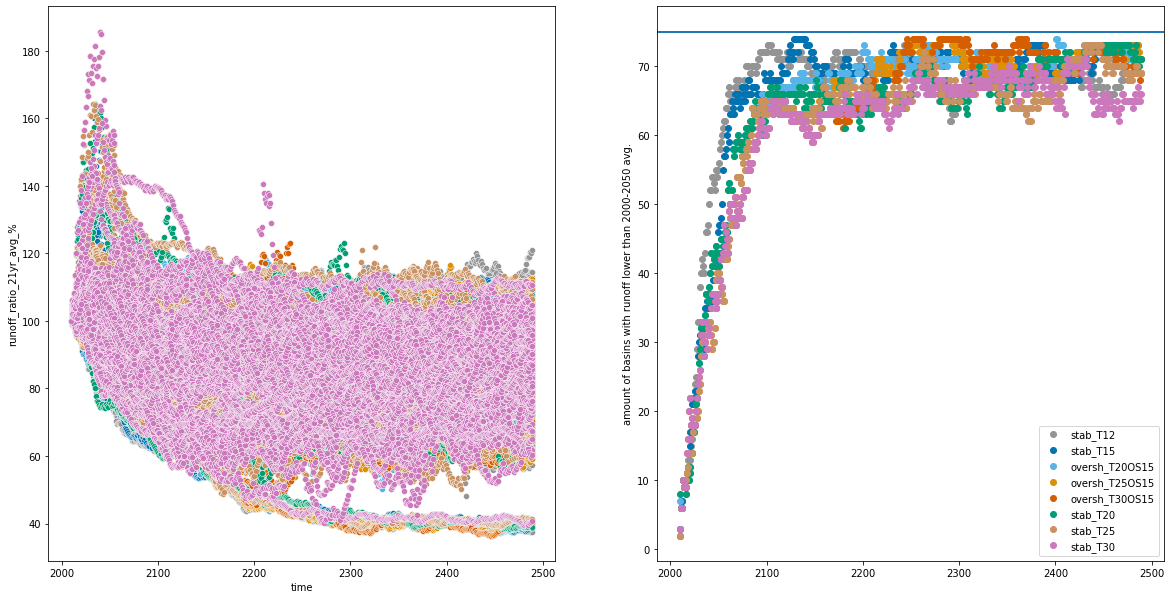

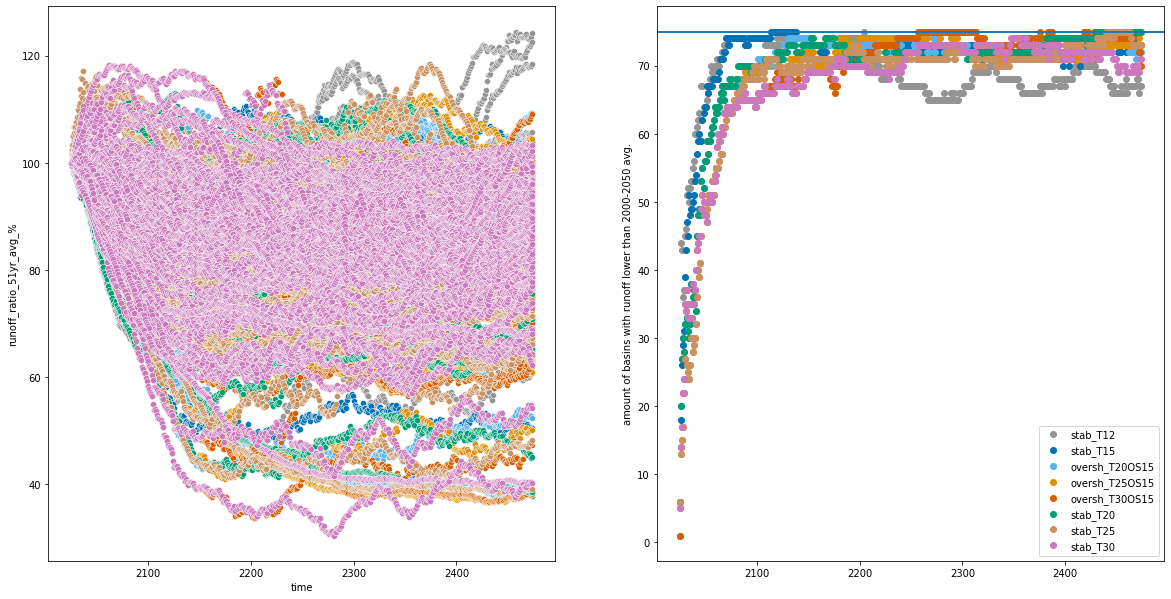

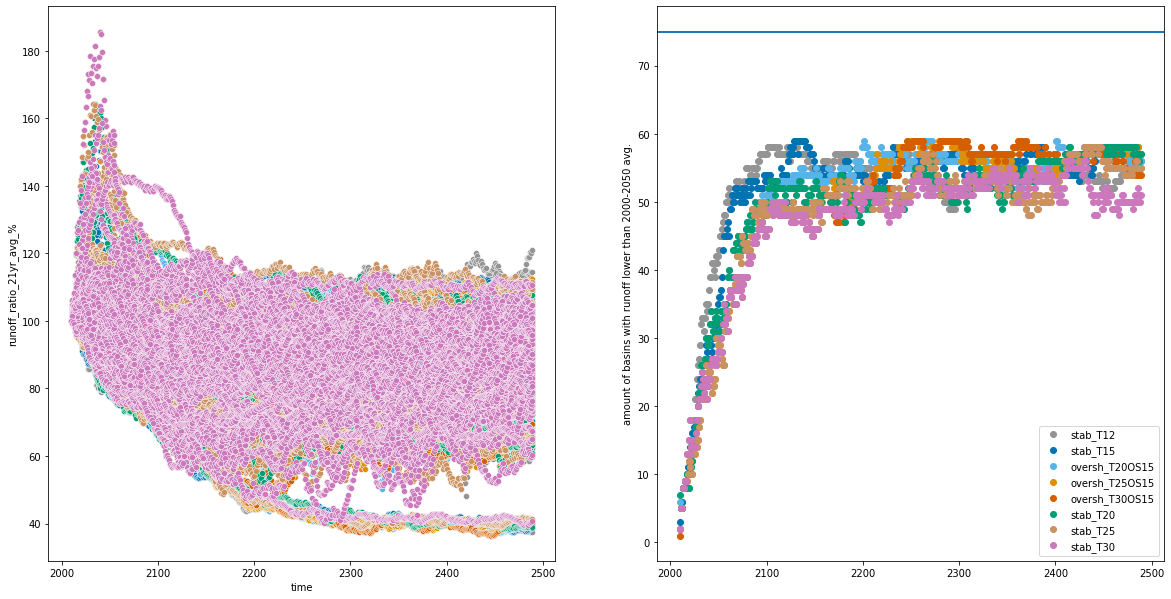

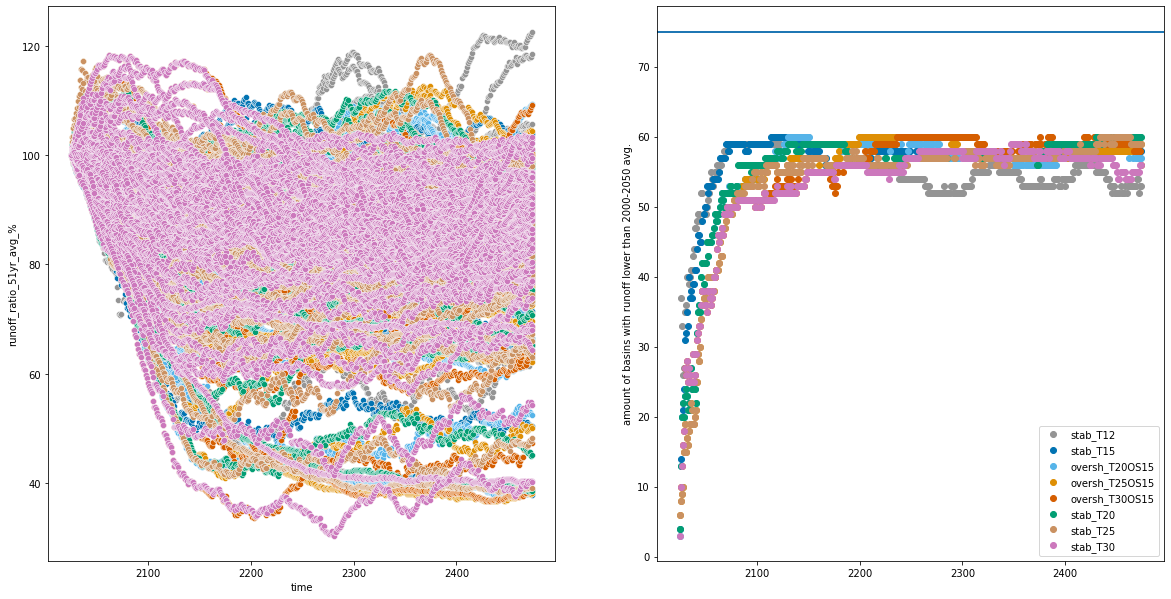

In [18]:
_pd_basin_num = gpd.read_file('/home/www/fmaussion/misc/magicc/basins_shape/glacier_basins.shp')
_pd_basin_num.index = _pd_basin_num.MRBID

for basin_sel in ['all', 'glac>0.1']:
    if basin_sel == 'all':
        basin_ids = pd_basin_num.MRBID.values
    else:
        basin_ids = pd_basin_num.loc[pd_basin_num.glaciated_vs_basin_area_RGI6_perc>=0.1].MRBID.values
    for avg in [21,51]: 

        plt.figure(figsize=(20,10))
        print(f'avg: {avg}-years')
        after_2100 = []
        after_2200 = []
        after_2300 = []
        after_2100_sel = []
        after_2200_sel = []
        if avg == 21:
            baseline = '2000-2020'
        else:
            baseline = '2000-2050'
        for scen in color_scenario.keys():
            basin_XXyr_runoff = df_scenario_common_basin.runoff.isel(time=slice(0,-1)).rolling(min_periods=avg, time=avg, center=True).mean().dropna(dim='time')
            basin_XXyr_runoff = basin_XXyr_runoff.sel(basin = basin_ids.astype(str))
            df_basin_XXyr_runoff_ratio = (100*basin_XXyr_runoff/basin_XXyr_runoff.isel(time=0)).to_dataframe(f'runoff_ratio_{avg}yr_avg_%').reset_index()
            df_basin_XXyr_runoff_ratio_scen= df_basin_XXyr_runoff_ratio.loc[df_basin_XXyr_runoff_ratio.scenario == scen]
            _d = df_basin_XXyr_runoff_ratio_scen.loc[df_basin_XXyr_runoff_ratio_scen[f'runoff_ratio_{avg}yr_avg_%']>=100]

            plt.subplot(121)
            c = color_scenario[scen]
            sns.scatterplot(data=df_basin_XXyr_runoff_ratio_scen, x='time', y = f'runoff_ratio_{avg}yr_avg_%', color=c)
            count_basin_below_init = df_basin_XXyr_runoff_ratio_scen.loc[df_basin_XXyr_runoff_ratio_scen[f'runoff_ratio_{avg}yr_avg_%']<100].groupby('time').count().reset_index()
            plt.subplot(122)
            plt.plot(count_basin_below_init.time, count_basin_below_init[f'runoff_ratio_{avg}yr_avg_%'], 'o', label=scen, color=c)
            plt.axhline(len(basin_glac),ls = '-')
            plt.ylabel('amount of basins with runoff lower than 2000-2050 avg.')
            print(scen, f'basins runoff below {baseline} avg over time 2100-2500:' , count_basin_below_init[f'runoff_ratio_{avg}yr_avg_%'].loc[count_basin_below_init.time>=2100].min(), 'of', len(basin_ids))
            after_2100.append(count_basin_below_init[f'runoff_ratio_{avg}yr_avg_%'].loc[count_basin_below_init.time>=2100].min())
            print(scen, f'basins runoff below {baseline} avg over time 2200-2500:' , count_basin_below_init[f'runoff_ratio_{avg}yr_avg_%'].loc[count_basin_below_init.time>=2200].min(), 'of', len(basin_ids))
            after_2200.append(count_basin_below_init[f'runoff_ratio_{avg}yr_avg_%'].loc[count_basin_below_init.time>=2200].min())
            
            print(scen, f'basins runoff below {baseline} avg over time 2300-2500:' , count_basin_below_init[f'runoff_ratio_{avg}yr_avg_%'].loc[count_basin_below_init.time>=2300].min(), 'of', len(basin_ids))
            after_2300.append(count_basin_below_init[f'runoff_ratio_{avg}yr_avg_%'].loc[count_basin_below_init.time>=2300].min())

            print(_pd_basin_num.loc[_d.loc[_d.time>=2100].basin.unique().astype(int)].RIVER_BASI.values)
            print(_pd_basin_num.loc[_d.loc[_d.time>=2200].basin.unique().astype(int)].RIVER_BASI.values)
            print(_pd_basin_num.loc[_d.loc[_d.time>=2300].basin.unique().astype(int)].RIVER_BASI.values)

            #### How many basins have runoff below 2000-2500 average (in 2100/2200)?
            #print((count_basin_below_init.loc[count_basin_below_init.time==2100]/len(basin_glac))['basin'])
            #print((count_basin_below_init.loc[count_basin_below_init.time==2200]/len(basin_glac))['basin'])
            #print(count_basin_below_init.loc[count_basin_below_init.time==2200]['basin'])
            if scen in ['stab_T20', 'stab_T25', 'stab_T30']:
                after_2100_sel.append(count_basin_below_init[f'runoff_ratio_{avg}yr_avg_%'].loc[count_basin_below_init.time>=2200].min())
                after_2200_sel.append(count_basin_below_init[f'runoff_ratio_{avg}yr_avg_%'].loc[count_basin_below_init.time>=2200].min())

        print('minimum after 2100', np.array(after_2100).min(), 'of', len(basin_ids))
        print('minimum after 2100 (>=stabT20)', np.array(after_2200_sel).min(), 'of', len(basin_ids))

        print('minimum after 2200', np.array(after_2200).min(), 'of', len(basin_ids))
        print('minimum after 2200 (>=stabT20)', np.array(after_2200_sel).min(), 'of', len(basin_ids))

        print('minimum after 2300', np.array(after_2300).min(), 'of', len(basin_ids))

        print('\n')
        plt.legend()

***Amount of all basins (from 75 basins) where runoff is below baseline after 2100***

In [19]:
(count_basin_below_init.loc[count_basin_below_init.time==2100]/len(basin_glac))['basin']
# 87%

75    0.68
Name: basin, dtype: float64

In [20]:
(count_basin_below_init.loc[count_basin_below_init.time==2200]/len(basin_glac))['basin']
# 93%

175    0.746667
Name: basin, dtype: float64

<BarContainer object of 450 artists>

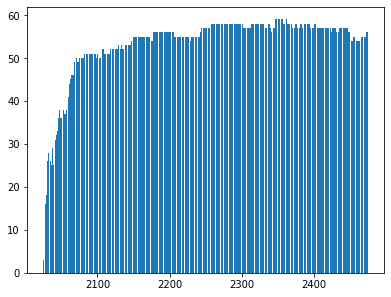

In [21]:
plt.bar(count_basin_below_init.time, count_basin_below_init['runoff_ratio_51yr_avg_%'])

In [22]:
# glaciated basins (from the 54) according to Ultee et al 2022
len(pd_basins.loc[pd_basins.glaciated_perc_ultee_2022>=0.1])

43

In [23]:
len(pd_basin_num.loc[pd_basin_num.AREA_CALC>5000])

72

In [24]:
# glaciated basins according to pd_basin_num (from the 75)
len(pd_basin_num.loc[pd_basin_num.glaciated_vs_basin_area_RGI6_perc>=0.1])

60

**get basin glacier volume and amount of glaciers per basin**

In [25]:
df_itmix = pd.read_hdf(oggm.utils.get_demo_file('rgi62_itmix_df.h5'))
print(len(df_itmix))
f = open('/home/www/fmaussion/misc/magicc/rgi_ids_per_basin.json')
t = json.load(f)

frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)

for basin in pd_basin_num.MRBID:
    rgis_basin = t[str(basin)]
    # remove connectivity level 2 glaciers only important for P03 (Greenland)
    rgis_basin = odf.loc[rgis_basin].loc[odf.loc[rgis_basin].Connect <2].index.values
    rgis_basin = list(set(rgis_basin))

    pd_basin_num.loc[pd_basin_num.MRBID==basin,'n glaciers'] = int(len(rgis_basin))
    vol_ratio = 100*df_itmix.loc[rgis_basin]['vol_itmix_m3'].sum()/df_itmix['vol_itmix_m3'].sum()
    pd_basin_num.loc[pd_basin_num.MRBID==basin,'Initial basin glacier volume relative to global volume (%)'] = np.round(vol_ratio,2)

pd_basin_num['n glaciers'] = pd_basin_num['n glaciers'].astype(int)

216502


In [26]:
runoff_var = 'runoff_rel_2000_2050_%'
water_trough_stats_basins = pd.DataFrame(index = pd_runoff_scenario_rel_basin.basin.unique(),
                                  columns= ['yrs_with_trough_water',  'cumulative_runoff_diff_trough', 
                                            'trough_water_min_year', 'trough_water_max_diff',
                                            'trough_water_pot_start_end'])
for basin in pd_runoff_scenario_rel_basin.basin.unique():
    pd_runoff_scenario_rel_basin_sel = pd_runoff_scenario_rel_basin.loc[pd_runoff_scenario_rel_basin.basin==basin]
    # overshoot runoff smaller than 0.95 times stabilisation runoff (both use 501r avg. runoff)
    sel_oversh = pd_runoff_scenario_rel_basin_sel.loc[pd_runoff_scenario_rel_basin_sel.scenario=='oversh_T30OS15']
    sel_stab = pd_runoff_scenario_rel_basin_sel.loc[pd_runoff_scenario_rel_basin_sel.scenario=='stab_T15']
    _output = get_basin_trough_water_stats(sel_stab, sel_oversh, 
                                 runoff_var = runoff_var)
    water_trough_stats_basins.loc[basin] = _output

print('amount of basins with annual runoff trough water: n=', len(water_trough_stats_basins.dropna()))



for basin in water_trough_stats_basins.index:
    pd_clim_sel_basin = pd_clim_all.loc[pd_clim_all.region ==f'basin_{basin}_glacier']
    pd_clim_sel_basin_oversh = pd_clim_sel_basin.loc[pd_clim_sel_basin.scenario=='oversh_T30OS15'].dropna()
    pd_clim_sel_basin_oversh.index = pd_clim_sel_basin_oversh.year
    pd_clim_sel_basin_stab = pd_clim_sel_basin.loc[pd_clim_sel_basin.scenario=='stab_T15'].dropna()
    pd_clim_sel_basin_stab.index = pd_clim_sel_basin_stab.year
    
    cumsum_temp_diff_oversh_stab_bef2350 = (pd_clim_sel_basin_oversh['temp_21yr_avg'].loc[2100:2350] - pd_clim_sel_basin_stab['temp_21yr_avg'].loc[2100:2350]).sum()
    cumsum_temp_diff_oversh_stab_aft2350 = (pd_clim_sel_basin_oversh['temp_21yr_avg'].loc[2350:] - pd_clim_sel_basin_stab['temp_21yr_avg'].loc[2350:]).sum()
    regional_warming_aft2350 = pd_clim_sel_basin_stab['temp_21yr_avg'].loc[2350:].mean()  - pd_clim_sel_basin_stab['temp_21yr_avg'].loc[2010].mean()
    diff = (pd_clim_sel_basin_oversh['temp_21yr_avg'].loc[2050:2350] - pd_clim_sel_basin_stab['temp_21yr_avg'].loc[2050:2350])
    yr_max = diff.idxmax()
    peak_temp_diff_oversh_vs_stab_bef2350 = diff.loc[yr_max]

    water_trough_stats_basins.loc[basin, 'peak_temp_diff_oversh_vs_stab_bef2350'] = peak_temp_diff_oversh_vs_stab_bef2350
    water_trough_stats_basins.loc[basin, 'yr_peak_temp_diff_oversh_vs_stab_bef2350'] = yr_max
    water_trough_stats_basins.loc[basin, 'regional_warming_aft2350'] = regional_warming_aft2350

    water_trough_stats_basins.loc[basin, 'cumsum_temp_diff_oversh_stab_bef2350']= cumsum_temp_diff_oversh_stab_bef2350
    water_trough_stats_basins.loc[basin, 'cumsum_temp_diff_oversh_stab_aft2350'] = cumsum_temp_diff_oversh_stab_aft2350
    #cumsum_precip_diff_oversh_stab_bef2350 = (pd_clim_sel_basin_oversh['precip_20yr_avg'].loc[2050:2350] - pd_clim_sel_basin_stab['precip_20yr_avg'].loc[2050:2350]).sum()
    #cumsum_precip_diff_oversh_stab_aft2350 = (pd_clim_sel_basin_oversh['precip_20yr_avg'].loc[2350:] - pd_clim_sel_basin_stab['precip_20yr_avg'].loc[2350:]).sum()

    mean_precip_change_perc_oversh_vs_stab_bef2350 = ((pd_clim_sel_basin_oversh['precip_21yr_avg'].loc[2100:2350] / pd_clim_sel_basin_stab['precip_21yr_avg'].loc[2100:2350]).mean() -1)*100
    mean_precip_change_perc_oversh_vs_stab_aft2350 = ((pd_clim_sel_basin_oversh['precip_21yr_avg'].loc[2350:] / pd_clim_sel_basin_stab['precip_21yr_avg'].loc[2350:]).mean() - 1)*100
    
    water_trough_stats_basins.loc[basin, 'mean_precip_change_perc_oversh_vs_stab_bef2350'] = mean_precip_change_perc_oversh_vs_stab_bef2350
    water_trough_stats_basins.loc[basin, 'mean_precip_change_perc_oversh_vs_stab_aft2350'] = mean_precip_change_perc_oversh_vs_stab_aft2350
    
    
    water_trough_stats_basins.loc[basin, 'corr_coef_oversh_temp_precip'] = np.corrcoef(pd_clim_sel_basin_oversh['temp_21yr_avg'], pd_clim_sel_basin_oversh['precip_21yr_avg'])[0][1]
    
    model = LinearRegression()
    model.fit(pd_clim_sel_basin_oversh['temp_21yr_avg'].values.reshape(-1,1), pd_clim_sel_basin_oversh['precip_21yr_avg'])
    slope = model.coef_[0]
    # slope_oversh_temp_precip describes how the precipiation changes with temperature, if positive, it means that prcp. increases, if positive it means it decreases with warmer temperatures ... 
    water_trough_stats_basins.loc[basin, 'slope_oversh_temp_precip'] = slope
    #ratio_change = (pd_clim_sel_basin_oversh['precip_20yr_avg'].loc[2050:2350] / pd_clim_sel_basin_stab['precip_20yr_avg'].loc[2050:2350]) - 1
    #yr_ratio_max = np.abs(ratio_change).idxmax()
    #peak_precip_change_perc_oversh_stab_bef2350 = (ratio_change.loc[yr_ratio_max])*100

    #ratio_change = (pd_clim_sel_basin_oversh['precip_20yr_avg'].loc[2400:] / pd_clim_sel_basin_stab['precip_20yr_avg'].loc[2400:]) - 1
    #yr_ratio_max = np.abs(ratio_change).idxmax()
    #peak_precip_change_perc_oversh_stab_aft2400 = (ratio_change.loc[yr_ratio_max])*100
    
# to compute basins where overshoot creates at least 10 % volume difference 
df_scenario_common_basin['melt_off_on_51yr_avg'] = df_scenario_common_basin.melt_off_on.isel(time=slice(0,-1)).rolling(min_periods=51, time=51, center=True).mean()
df_volume_rel = 100 * df_scenario_common_basin.volume.dropna(dim='time') / df_scenario_common_basin.volume.dropna(dim='time').sel(time=2020)
df_runoff_rel = 100 * df_scenario_common_basin.runoff_51_yr_avg.dropna(dim='time') / df_scenario_common_basin.runoff_51_yr_avg.dropna(dim='time').isel(time=0)
df_melt_off_on_rel = 100 * df_scenario_common_basin.melt_off_on_51yr_avg.dropna(dim='time') / df_scenario_common_basin.melt_off_on_51yr_avg.dropna(dim='time').isel(time=0)
df_runoff_rel_sel = df_runoff_rel.drop_sel(scenario='stab_T12')

rel_volume_basin = 100*df_scenario_common_basin.volume/df_scenario_common_basin.volume.sel(time=2020)
# only select those years where overshoot results in smaller volume
max_volume_diff = (rel_volume_basin.sel(scenario='stab_T15') - rel_volume_basin.sel(scenario='oversh_T30OS15')).max(dim='time').squeeze().to_dataframe('Values')
yr_w_max_volume_diff = (rel_volume_basin.sel(scenario='stab_T15') - rel_volume_basin.sel(scenario='oversh_T30OS15')).idxmax(dim='time').squeeze().to_dataframe('Values')

final_volume_diff_stab_T15_T30 = (rel_volume_basin.sel(scenario='stab_T15') - rel_volume_basin.sel(scenario='stab_T30')).sel(time=2499).squeeze().to_dataframe('Values')
water_trough_stats_basins.loc[max_volume_diff.index, 'max_volume_diff_perc_stab_T15_vs_oversh30'] = max_volume_diff['Values']
water_trough_stats_basins.loc[yr_w_max_volume_diff.index, 'yr_with_max_volume_diff_stab_T15_vs_oversh30'] = yr_w_max_volume_diff['Values']

water_trough_stats_basins.loc[max_volume_diff.index, 'final_volume_diff_stab_T15_T30'] = final_volume_diff_stab_T15_T30['Values']

water_trough_stats_basins['trough_water_max_diff'] = water_trough_stats_basins.trough_water_max_diff.astype(float)
water_trough_stats_basins['max_volume_diff_perc_stab_T15_vs_oversh30'] = water_trough_stats_basins.max_volume_diff_perc_stab_T15_vs_oversh30.astype(float)
water_trough_stats_basins['yrs_with_trough_water'] = water_trough_stats_basins.yrs_with_trough_water.astype(float)
water_trough_stats_basins['mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350'] = water_trough_stats_basins['mean_precip_change_perc_oversh_vs_stab_bef2350'] / water_trough_stats_basins['mean_precip_change_perc_oversh_vs_stab_aft2350']

water_trough_stats_basins.loc[pd_basin_num.MRBID.values.astype(str), 'basin_name'] = pd_basin_num.index


# at least 0.1% glaciation 
basin_glac_ind = pd_basin_num.where(pd_basin_num['glaciated_vs_basin_area_RGI6_perc']>=0.1).dropna(how='all').MRBID.astype(int).astype(str).values
water_trough_stats_basins_sel = water_trough_stats_basins.loc[basin_glac_ind].copy()
print(f'basins 0.1% glaciated:n = {len(water_trough_stats_basins_sel)}')


condi_after_2150 = water_trough_stats_basins_sel['yr_with_max_volume_diff_stab_T15_vs_oversh30']>2150 #2150#2100
condi_vol_diff = water_trough_stats_basins_sel['max_volume_diff_perc_stab_T15_vs_oversh30']>10
print('basins that get an at least 10% larger glacier mass after the global overshoot:')
print(len(water_trough_stats_basins_sel['max_volume_diff_perc_stab_T15_vs_oversh30'].where(condi_vol_diff & condi_after_2150).dropna(how='all')))

# assert np.all(water_trough_stats_basins_sel.water_trough_min_year.astype(float).dropna(how='all') > 2170)
condi_water_trough_2170 = water_trough_stats_basins_sel.trough_water_min_year.astype(float).dropna(how='all') > 2170
condi_trough = water_trough_stats_basins_sel.yrs_with_trough_water>=20
print('basins that are 0.1% glaciated, have at least a mass difference of 10% and create a trough water:')
print(len(water_trough_stats_basins_sel.where(condi_trough & condi_vol_diff).dropna(how='all')))
# check if the water trough occurs after overshoot 
print('basins that are 0.1% glaciated, have at least a mass difference of 10% after the global overshoot and create a trough water:')
print(len(water_trough_stats_basins_sel.where(condi_trough & condi_vol_diff & condi_after_2150).dropna(how='all')))

# all that have a trough and have at least 10%  lager glacier volume 
print('basins that are 0.1% glaciated, and create a trough water after the year 2170:')
print(len(water_trough_stats_basins_sel.where(condi_trough  & condi_water_trough_2170).dropna(how='all')))

# all that have a trough and have at least 10%  lager glacier volume 
print('basins that are 0.1% glaciated, have at least a mass difference of 10% after the global overshoot and create a trough water after the year 2170:')
print(len(water_trough_stats_basins_sel.where(condi_trough & condi_vol_diff & condi_after_2150 & condi_water_trough_2170).dropna(how='all')))
#print(water_trough_stats_basins_sel.dropna())
#assert len(water_trough_stats_basins_sel.where(condi_trough & condi_vol_diff & condi_after_2150).dropna()) == len(water_trough_stats_basins_sel.where(condi_trough).dropna())




amount of basins with annual runoff trough water: n= 37
basins 0.1% glaciated:n = 60
basins that get an at least 10% larger glacier mass after the global overshoot:
46
basins that are 0.1% glaciated, have at least a mass difference of 10% and create a trough water:
32
basins that are 0.1% glaciated, have at least a mass difference of 10% after the global overshoot and create a trough water:
25
basins that are 0.1% glaciated, and create a trough water after the year 2170:
31
basins that are 0.1% glaciated, have at least a mass difference of 10% after the global overshoot and create a trough water after the year 2170:
24


**THese are the numbers used in the main manuscript text**:
- Overall, annual glacier runoff trough water occurs in 31 of 60 glaciated basins after the year 2170 (Supplementary Fig...).
- Of those, 24 basins show a trough water attributable to glacier mass regrowth after the temperature overshoot.

In [27]:
#### basins 0.1% glaciated, that get an at least 10% larger glacier volume and create a trough water:
len(water_trough_stats_basins_sel.where(condi_trough).dropna())  # trough water minimum can be before 2150 

32

In [28]:
#### basins 0.1% glaciated, that get an at least 10% larger glacier volume and create a trough water:
len(water_trough_stats_basins_sel.where(condi_trough & condi_vol_diff).dropna())  # trough water minimum can be before 2150 

32

In [29]:
###  basins 0.1\% glaciated, that get an at least 10\% larger glacier volume and create a trough water after the year 2170
len(water_trough_stats_basins_sel.where(condi_trough & condi_water_trough_2170).dropna())

31

In [30]:
###  basins 0.1\% glaciated, that get an at least 10\% larger glacier volume and create a trough water after the year 2170
len(water_trough_stats_basins_sel.where(condi_trough & condi_vol_diff  & condi_water_trough_2170).dropna())

31

- five out of the seven driest basins are included here !!! 

In [31]:
len(water_trough_stats_basins_sel.loc[water_trough_stats_basins_sel.max_volume_diff_perc_stab_T15_vs_oversh30>=10])

56

#### also compute the melt water stuff (just as comparison)    

In [32]:

runoff_var = 'melt_off_on_rel_2000_2050_%'
melt_water_trough_stats_basins = pd.DataFrame(index = pd_melt_off_on_scenario_rel_basin.basin.unique(),
                                              columns= ['yrs_with_melt_trough_water',  'cumulative_melt_off_on_diff_trough', 
                                            'melt_trough_water_min_year', 'melt_trough_water_max_diff',
                                            'melt_trough_water_pot_start_end'])
for basin in pd_melt_off_on_scenario_rel_basin.basin.unique():
    pd_melt_off_on_scenario_rel_basin_sel = pd_melt_off_on_scenario_rel_basin.loc[pd_melt_off_on_scenario_rel_basin.basin==basin].copy()
    sel_oversh = pd_melt_off_on_scenario_rel_basin_sel.loc[pd_melt_off_on_scenario_rel_basin_sel.scenario=='oversh_T30OS15']
    sel_stab = pd_melt_off_on_scenario_rel_basin_sel.loc[pd_melt_off_on_scenario_rel_basin_sel.scenario=='stab_T15']
    _output = get_basin_trough_water_stats(sel_stab, sel_oversh, 
                                 runoff_var = runoff_var)
    melt_water_trough_stats_basins.loc[basin] = _output
    
print('amount of basins with melt water trough water: n=', len(melt_water_trough_stats_basins.dropna()))


amount of basins with melt water trough water: n= 59


### **create some overview plots of annual runoff trough water for every basin**

In [33]:
pd_clim_all['precip_51yr_avg'] = pd_clim_all['precip_51yr_avg'].where((pd_clim_all.year>=2025) & (pd_clim_all.year<=2474))

In [34]:
pd_runoff_scenario_rel_basin['stab_vs_oversh'] = 'oversh'
pd_runoff_scenario_rel_basin.loc[pd_runoff_scenario_rel_basin['scenario'].apply(lambda x: 'stab' in x).values, 'stab_vs_oversh'] = 'stab'

#### some per-basin figures (here in subplots for every PROVIDE region, which are sometimes larger than RGI regions and always include entire basins) which are slighlty 

In [37]:
pd_runoff_scenario_rel_basin

basin        scenario         gcm    time bias_correction  \
0       4110  oversh_T20OS15  GFDL-ESM2M  2000.0    bc_1980_2019   
1       4110  oversh_T20OS15  GFDL-ESM2M  2001.0    bc_1980_2019   
2       4110  oversh_T20OS15  GFDL-ESM2M  2002.0    bc_1980_2019   
3       4110  oversh_T20OS15  GFDL-ESM2M  2003.0    bc_1980_2019   
4       4110  oversh_T20OS15  GFDL-ESM2M  2004.0    bc_1980_2019   
...      ...             ...         ...     ...             ...   
300595  5406        stab_T30  GFDL-ESM2M  2496.0    bc_1980_2019   
300596  5406        stab_T30  GFDL-ESM2M  2497.0    bc_1980_2019   
300597  5406        stab_T30  GFDL-ESM2M  2498.0    bc_1980_2019   
300598  5406        stab_T30  GFDL-ESM2M  2499.0    bc_1980_2019   
300599  5406        stab_T30  GFDL-ESM2M  2500.0    bc_1980_2019   

        runoff_rel_2000_2050_% stab_vs_oversh  
0                          NaN         oversh  
1                          NaN         oversh  
2                          NaN         oversh  
3                          NaN         oversh  
4                          NaN         oversh  
...                        ...            ...  
300595                     NaN           stab  
300596                     NaN           stab  
300597                     NaN           stab  
300598                     NaN           stab  
300599                     NaN           stab  

[300600 rows x 7 columns]

dict_keys(['P10', 'P01', 'P07', 'P08', 'P09', 'P04', 'P11', 'P12', 'P06', 'P05', 'P03', 'P02', 'P13'])

In [40]:
var = 'precip_51yr_avg'
for Preg in basins_per_preg.keys():
    basins = basins_per_preg[Preg]
    preg_name = provide_reg_full_name_dict[Preg]
    preg_name.replace('\n','')
        
    if len(basins)<1:
        continue
        
    plt.rc('font', size=22)

    plt.figure(figsize=(32,35)) #, sharey=True, sharex=True)
    plt.subplot(5,4,1)
    ax = plt.gca()

    ax.set_ylabel('Annual runoff\n(% rel. to 2000-2050)', weight='bold')

    basin = basins[0]
    basin_n = pd_basin_num.loc[pd_basin_num.MRBID==int(basin)]['RIVER_BASI'].values[0].split()[0]
    basin_name = f'{preg_name} ({Preg})'
    plt.suptitle(basin_name)
    plt.text(0.97,0.97, f'{basin_n}:\n{basin}',
             transform=ax.transAxes,ha='right',va='top',
            color='grey', fontsize=22)

    sns.lineplot(data=pd_runoff_scenario_rel_basin.loc[pd_runoff_scenario_rel_basin.basin == str(basin)],
                 hue='scenario', x='time', y= 'runoff_rel_2000_2050_%', 
                 palette=list_color_scenario_poster_new_order,
                 style='stab_vs_oversh', style_order=['stab', 'oversh'],
                 hue_order=scenarios,lw=4, legend=True,
                 ax = ax)
    #ax.set_xlabel('Year')
    #ax.grid(axis='x')
    ax.set_yticks(ticks=[0,25,50,75,100,125],
                       labels=[0,25,50,75,100,125], weight='bold')

    for axis in 'left', 'bottom':
        ax.spines[axis].set_linewidth(1.5)

    # set the parameters for both axis: label size in font points, the line tick line 
    # width and length in pixels
    ax.tick_params(axis='both', which='major', width=2, length=10)
    ax2 = ax.twinx()  
    for scenario in scenarios:
                    #'stab_T30']:

        pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
        pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'basin_{basin}_glacier']
        pd_clim_scenario_g.index = pd_clim_scenario_g.year
        temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
        if var == 'temp_21yr_avg':
            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
        else:
            var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g

        ax2.plot(pd_clim_scenario_g.year,
                 var_g_to_ref,
                 alpha = 1, 
                 ls = scenario_ls[scenario],
                 lw=1, color = color_scenario[scenario], label=label_scenario[scenario])
    ax2.set_ylabel('')
    if var != 'temp_21yr_avg':
        ticks = np.arange(95,125,5)
        ax2.set_yticks(ticks=ticks,
                        labels=ticks, alpha=0.6)  
    else:
        ax2.set_yticks(ticks=[0,1,2,3,4,5],
                   labels=[0,1,2,3,4,5], alpha=0.6)

    ax2.set_ylim([75,128]);
    plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
    ax.set_xlabel('')
    ax.set_xlim([2000,2500])
    ax2.set_xlim([2000,2500])
    ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
    ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
    ax.set_ylim([40,145]);


    ### add legends
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    handles_2, labels_2 = ax2.get_legend_handles_labels()
    leg = ax.legend(handles_2[0:len(scenarios)], # here stab 112 is handle 0 (but invisible)
                    labels_2[:len(scenarios)], title='Scenarios', fontsize=20, title_fontsize=22, loc = 'upper left')
    for l in leg.get_lines():
        l.set_linewidth(4)
    leg2 = ax.legend([handles[1], handles_2[0]], ['Runoff (left)',
                                                  'Precipitation (right)'],
                     loc='lower right', ncol=1, fontsize=20)
    leg2.get_lines()[0].set_linewidth(4)
    leg2.get_lines()[1].set_linewidth(2)
    for l in leg2.get_lines():
        l.set_color('grey')
    ax.add_artist(leg)

    try:
        y0,y1 = water_trough_stats_basins['trough_water_pot_start_end'].loc[str(basin)].split('_')
        pd_basin_sel = pd_runoff_scenario_rel_basin.loc[pd_runoff_scenario_rel_basin.basin == str(basin)].dropna()
        pd_basin_sel_stab_T15_runoff = pd_basin_sel.loc[pd_basin_sel.scenario=='stab_T15'] #['runoff_rel_2000_2050_%']
        pd_basin_sel_stab_T15_runoff.index = pd_basin_sel_stab_T15_runoff.time
        pd_basin_sel_oversh_T30OS15_runoff = pd_basin_sel.loc[pd_basin_sel.scenario=='oversh_T30OS15'] #['runoff_rel_2000_2050_%']
        pd_basin_sel_oversh_T30OS15_runoff.index = pd_basin_sel_oversh_T30OS15_runoff.time
        nyears,water_trough_max_diff  = water_trough_stats_basins[['yrs_with_trough_water',
                                                            'trough_water_max_diff']].loc[str(basin)]
        water_trough_max_diff = np.round(float(water_trough_max_diff),0)
        add_label = f'for {int(nyears)} years,\n' + r'$\Delta_{max}$=-'+f'{int(water_trough_max_diff)}%'
        
        condi_5perc = (pd_basin_sel_oversh_T30OS15_runoff['runoff_rel_2000_2050_%']-pd_basin_sel_stab_T15_runoff['runoff_rel_2000_2050_%']).loc[float(y0):float(y1)+1]<=-5
        # pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'].where(condi_5perc)
        # important -> keep the NaNs to show the potential incontinuoties ... 
        ax.fill_between(pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1].time.where(condi_5perc),  
                         pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1]['runoff_rel_2000_2050_%'].where(condi_5perc), 
                         pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_rel_2000_2050_%'].where(condi_5perc),
                         alpha = 0.15, color='cyan', zorder=-1, label='trough water\n'+add_label)
        
        handles_x, labels_x = ax.get_legend_handles_labels()
        leg3 = ax.legend([handles_x[-1]], [labels_x[-1]], loc='lower left',fontsize=18)
        #ax.add_artist(leg3)
        ax.add_artist(leg2)
    except AttributeError:
        pass
    

    for j, basin in enumerate(basins[1:]):
        basin_n = pd_basin_num.loc[pd_basin_num.MRBID==int(basin)]['RIVER_BASI'].values[0].split()[0]

        plt.subplot(5,4,j+2)
        x_j = np.arange(3,20,4)
        x2_j = np.arange(2,20,4)
            
        ax = plt.gca()
        sns.lineplot(data=pd_runoff_scenario_rel_basin.loc[pd_runoff_scenario_rel_basin.basin == str(basin)],
                     hue='scenario', x='time', y= 'runoff_rel_2000_2050_%', 
                     style='stab_vs_oversh',style_order=['stab', 'oversh'],
                     palette=list_color_scenario_poster_new_order,
                 hue_order=scenarios,lw=4, legend=False,
                 ax = ax)

        #ax.set_title(f'{Preg}: {basin}')
        plt.text(0.97,0.97, f'{basin_n}:\n{basin}',
                 transform=ax.transAxes,ha='right',va='top',
                 color='grey', fontsize=22)

        if j in x_j:
            plt.ylabel(f'Annual runoff\n(% rel. to 2000-2050)', weight='bold')
            ax.set_yticks(ticks=[0,25,50,75,100,125],
                       labels=[0,25,50,75,100,125], weight='bold')
        else:
            plt.ylabel('')
            ax.set_yticks(ticks=[0,25,50,75,100,125],
                       labels=[0,25,50,75,100,125], alpha=0, fontsize=1) #visible=False) 
            #plt.setp(ax.get_yticklabels(), visible=False)

        #ax.set_ylim([70,1439.9]);


        ax.tick_params(axis='both', which='major', width=2.5, length=10)
        ax2 = ax.twinx()  
        for scenario in scenarios:
                        #'stab_T30']:

            pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
            pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'basin_{basin}_glacier']
            pd_clim_scenario_g.index = pd_clim_scenario_g.year
            temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
            if var == 'temp_21yr_avg':
                var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
            else:
                var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g

            ax2.plot(pd_clim_scenario_g.year,
                     var_g_to_ref,
                     alpha = 1, 
                    ls = scenario_ls[scenario],
                     lw=1, color = color_scenario_poster[scenario], label=label_scenario[scenario])
        if var != 'temp_21yr_avg':
            ticks = np.arange(95,125,5)
            ax2.set_yticks(ticks=ticks,
                            labels=ticks, alpha=0.6)  
            ylabel = 'Precipitation\n(% rel. to 2000-2019)'

        else:
            ax2.set_yticks(ticks=[0,1,2,3,4,5],
                       labels=[0,1,2,3,4,5], alpha=0.6)
            ylabel = r'$\Delta$T'+'(°C) rel. to 2000-2019\n(glacier-area weighted)'

        if j in x2_j:
            ax2.set_ylabel(ylabel,
                          alpha = 0.6)
            #ax2.set_yticks(labels=[0,1,2,3,4], alpha=0.6)
        else:
            ax2.set_ylabel('')
            #ax2.set_yticks([])
            plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)

        #ax2.set_ylim([-0.9,5.9]);
        ax2.set_ylim([75,128]);

        if j >5:
            ax.set_xlabel('Year')
        else:
            ax.set_xlabel('')
        ax.set_xlim([2000,2500])
        ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
        ax2.set_xlim([2000,2500])
        ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
        ax.set_ylim([40,145]);
        
        try:
            y0,y1 = water_trough_stats_basins['trough_water_pot_start_end'].loc[str(basin)].split('_')
            pd_basin_sel = pd_runoff_scenario_rel_basin.loc[pd_runoff_scenario_rel_basin.basin == str(basin)].dropna()
            pd_basin_sel_stab_T15_runoff = pd_basin_sel.loc[pd_basin_sel.scenario=='stab_T15'] #['runoff_rel_2000_2050_%']
            pd_basin_sel_stab_T15_runoff.index = pd_basin_sel_stab_T15_runoff.time
            pd_basin_sel_oversh_T30OS15_runoff = pd_basin_sel.loc[pd_basin_sel.scenario=='oversh_T30OS15'] #['runoff_rel_2000_2050_%']
            pd_basin_sel_oversh_T30OS15_runoff.index = pd_basin_sel_oversh_T30OS15_runoff.time
            nyears,water_trough_max_diff  = water_trough_stats_basins[['yrs_with_trough_water',
                                                                'trough_water_max_diff']].loc[str(basin)]
            water_trough_max_diff = np.round(float(water_trough_max_diff),0)
            add_label = f'for {int(nyears)} years,\n' + r'$\Delta_{max}$=-'+f'{int(water_trough_max_diff)}%'

            condi_5perc = (pd_basin_sel_oversh_T30OS15_runoff['runoff_rel_2000_2050_%']-pd_basin_sel_stab_T15_runoff['runoff_rel_2000_2050_%']).loc[float(y0):float(y1)+1]<=-5
            # pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'].where(condi_5perc)
            # important -> keep the NaNs to show the potential incontinuoties ... 
            ax.fill_between(pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1].time.where(condi_5perc),  
                             pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1]['runoff_rel_2000_2050_%'].where(condi_5perc), 
                             pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_rel_2000_2050_%'].where(condi_5perc),
                             alpha = 0.15, color='cyan', zorder=-1, label='trough water\n'+add_label)
            handles_x, labels_x = ax.get_legend_handles_labels()
            leg3 = ax.legend([handles_x[-1]], [labels_x[-1]], loc='lower left',fontsize=18)
        except AttributeError:
            pass
        
    plt.tight_layout()
    plt.savefig(f'../figures/additional_figures/3_suppl_{Preg}_basin_runoff_{bc}_vs_prcp_poster_iugg_precip_51yr_avg.png')
    plt.close()

**Let's just choose the 7 most arid basins that are at least 0.9% glaciated** (can only choose from the 56 basins with aridity index from Ultee et al...)

From the 7 most arid basins that are at least 0.9% glaciated, 5 create a trough water for more than 100 years after the temperature overshoot

In [41]:
pd_basins_arid_glac_num = pd_basin_num.loc[(pd_basin_num.aridity_index_ultee_2022 <2) & (pd_basin_num.glaciated_vs_basin_area_RGI6_perc >0.9)].sort_values(by='glaciated_vs_basin_area_RGI6_perc', ascending = False)

In [42]:
pd_basins_arid_glac_num

MRBID                 RIVER_BASI      CONTINENT  \
RIVER_BASI                                                                   
INDUS                       2309                      INDUS           Asia   
SANTA                       3425                      SANTA  South America   
YSYK-KOL (also ISSYK-KUL)   2919  YSYK-KOL (also ISSYK-KUL)           Asia   
RAPEL                       3423                      RAPEL  South America   
TARIM HE (also TALIMU HE)   2914  TARIM HE (also TALIMU HE)           Asia   
RHONE                       6243                      RHONE         Europe   
ARAL SEA                    2902                   ARAL SEA           Asia   

                                    OCEAN                SEA  AREA_CALC  \
RIVER_BASI                                                                
INDUS                        Indian Ocean        Arabian Sea   865012.6   
SANTA                       Pacific Ocean      South Pacific    11979.2   
YSYK-KOL (also ISSYK-KUL)             ---                ---    21918.0   
RAPEL                       Pacific Ocean      South Pacific    13784.5   
TARIM HE (also TALIMU HE)             ---                ---  1563201.7   
RHONE                      Atlantic Ocean  Mediterranean Sea    96637.6   
ARAL SEA                              ---                ---  1372516.9   

                           Shape_Leng  Shape_Area   RGI_AREA  \
RIVER_BASI                                                     
INDUS                       81.286291   82.852275  27206.546   
SANTA                        8.161008    0.980699    354.427   
YSYK-KOL (also ISSYK-KUL)    8.855285    2.401350    507.862   
RAPEL                        6.920319    1.351493    234.273   
TARIM HE (also TALIMU HE)   93.222224  163.124573  26142.022   
RHONE                       28.004916   11.197342    917.302   
ARAL SEA                   126.456933  146.833583  12558.726   

                                                                    geometry  \
RIVER_BASI                                                                     
INDUS                      MULTIPOLYGON (((67.44167 23.97006, 67.44028 23...   
SANTA                      POLYGON ((-77.1875 -9.8375, -77.18715 -9.85659...   
YSYK-KOL (also ISSYK-KUL)  POLYGON ((79.21667 42.41667, 79.2125 42.41667,...   
RAPEL                      POLYGON ((-70.02917 -34.2875, -70.02864 -34.28...   
TARIM HE (also TALIMU HE)  POLYGON ((98.90833 38.2875, 98.88924 38.28715,...   
RHONE                      POLYGON ((6.84167 47.82083, 6.84167 47.81667, ...   
ARAL SEA                   POLYGON ((60.0375 48.5625, 60.02674 48.56215, ...   

                           glaciated_vs_basin_area_RGI6_perc  \
RIVER_BASI                                                     
INDUS                                               3.145220   
SANTA                                               2.958687   
YSYK-KOL (also ISSYK-KUL)                           2.317100   
RAPEL                                               1.699539   
TARIM HE (also TALIMU HE)                           1.672338   
RHONE                                               0.949219   
ARAL SEA                                            0.915014   

                           aridity_index_ultee_2022  n glaciers  \
RIVER_BASI                                                        
INDUS                                          0.54       23424   
SANTA                                          1.50         409   
YSYK-KOL (also ISSYK-KUL)                      0.55         807   
RAPEL                                          0.67         246   
TARIM HE (also TALIMU HE)                      0.64       20791   
RHONE                                          1.90        1169   
ARAL SEA                                       0.45       16211   

                           Initial basin glacier volume relative to global volume (%)  
RIVER_BASI                                                                       

#### 51 yr average prcp and runoff of selected basins

[<matplotlib.lines.Line2D object at 0x7f0f02035780>, <matplotlib.lines.Line2D object at 0x7f0f02035b10>, <matplotlib.lines.Line2D object at 0x7f0f02036650>, <matplotlib.lines.Line2D object at 0x7f0f02036320>, <matplotlib.lines.Line2D object at 0x7f0f02036770>, <matplotlib.lines.Line2D object at 0x7f0f020371f0>, <matplotlib.lines.Line2D object at 0x7f0f020373d0>]
no trough water: 3425


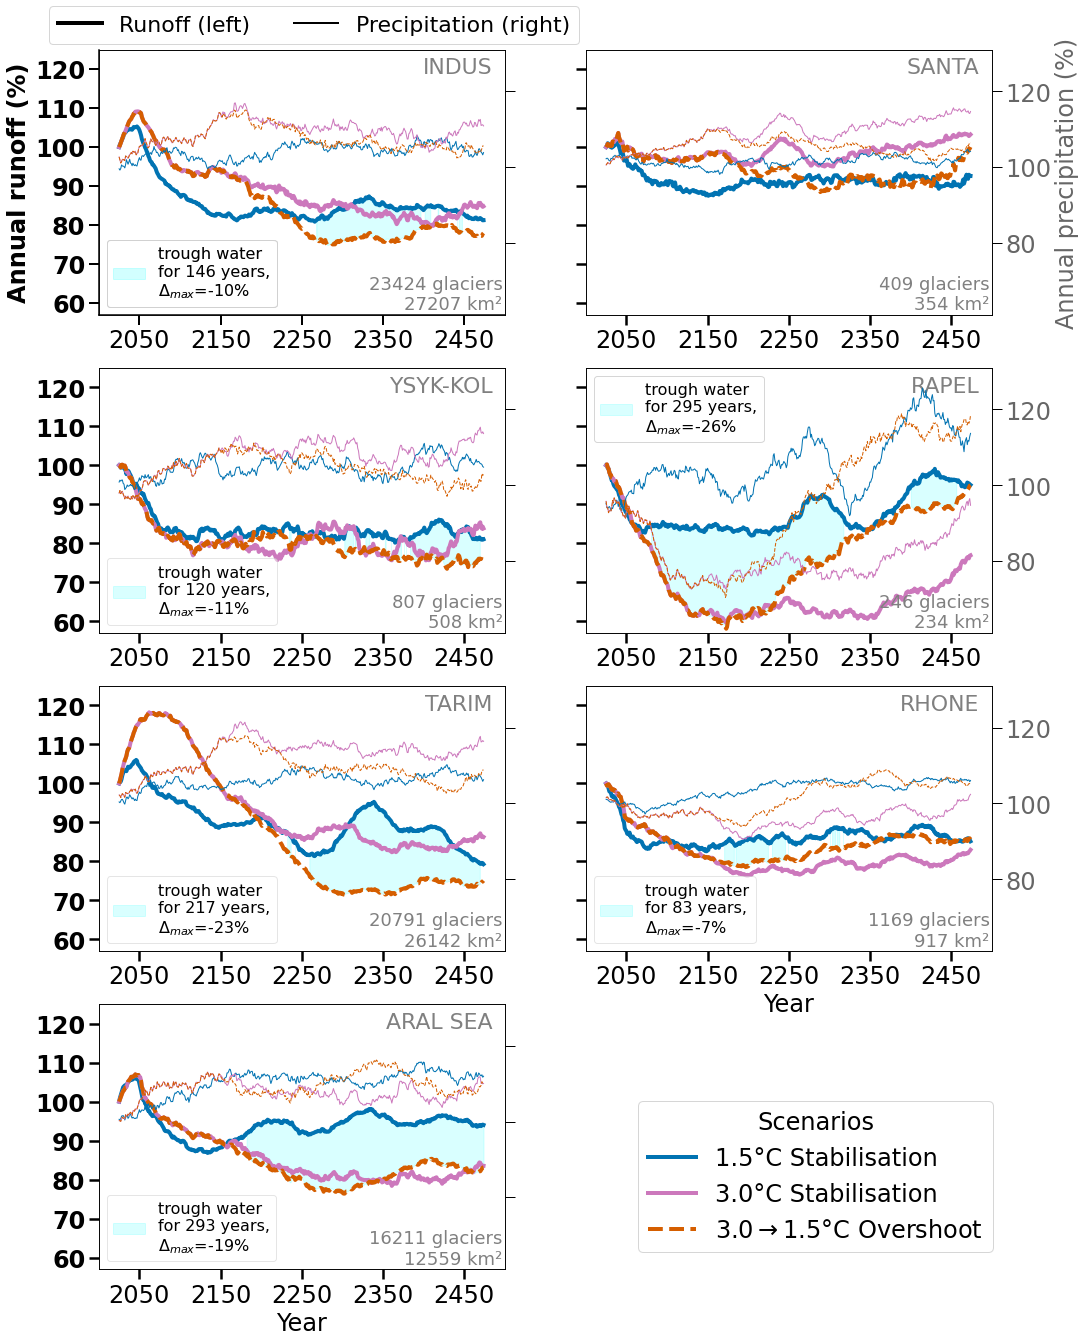

In [43]:
var = 'precip_51yr_avg'
basins = pd_basins_arid_glac_num.MRBID.values

plt.rc('font', size=24)

plt.figure(figsize=(16,22)) #, sharey=True, sharex=True)
plt.subplot(4,2,1)
ax = plt.gca()

ax.set_ylabel('Annual runoff (%)', weight='bold') # rel. to 2000-2050

basin = basins[0]
basin_n = pd_basin_num.loc[pd_basin_num.MRBID==int(basin)]['RIVER_BASI'].values[0]#.split()#[0]
n_glaciers = pd_basins_arid_glac_num.loc[pd_basins_arid_glac_num.MRBID==int(basin), 'n glaciers'].values[0]
glac_area = int(pd_basins_arid_glac_num.loc[pd_basins_arid_glac_num.MRBID==int(basin), 'RGI_AREA'].values.round(0))

continent_n = pd_basin_num.loc[pd_basin_num.MRBID==int(basin)]['CONTINENT'].values[0]#.split()#[0]
#basin_name = f'{continent_n}: {basin_n}'
basin_name = f'{basin_n}'

#ax.set_title(basin_name)
sns.lineplot(data=pd_runoff_scenario_rel_basin.loc[pd_runoff_scenario_rel_basin.basin == str(basin)],
             hue='scenario', x='time', y= 'runoff_rel_2000_2050_%', 
             palette=list_color_scenario_poster_new_order,
             style = 'stab_vs_oversh',
             style_order=['stab', 'oversh'],
             hue_order=scenarios,lw=4, legend=True,
             ax = ax)
#ax.set_xlabel('Year')
#ax.grid(axis='x')
ax.set_yticks(ticks=np.arange(0,150,10),
              labels=np.arange(0,150,10), weight='bold')

for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)

# set the parameters for both axis: label size in font points, the line tick line 
# width and length in pixels
ax.tick_params(axis='both', which='major', width=2, length=10)
ax2 = ax.twinx()  
for scenario in scenarios:
                #'stab_T30']:

    pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
    pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'basin_{basin}_glacier']
    pd_clim_scenario_g.index = pd_clim_scenario_g.year
    temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
    if var == 'temp_20yr_avg':
        var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
    else:
        var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g

    ax2.plot(pd_clim_scenario_g.year,
             var_g_to_ref,
             alpha = 1, 
             ls = scenario_ls[scenario],
             lw=1, color = color_scenario[scenario], label=label_scenario[scenario])
ax2.set_ylabel('')
if var != 'temp_20yr_avg':
    ticks = np.arange(80,131,20)
    ax2.set_yticks(ticks=ticks,
                    labels=ticks, alpha=0.6) 
else:
    ax2.set_yticks(ticks=[0,1,2,3,4,5],
               labels=[0,1,2,3,4,5], alpha=0.6)

plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
ax.set_xlabel('')
ax.set_xlim([2000,2500])
ax2.set_xlim([2000,2500])
ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])

ax.set_ylim([57,125]);
ax2.set_ylim([61,131]);


### add legends
handles, labels = ax.get_legend_handles_labels()
handles_2, labels_2 = ax2.get_legend_handles_labels()
leg = ax.legend(handles[:len(scenarios)], labels_2[:len(scenarios)], #title='Scenarios',
                fontsize=20, title_fontsize=22,loc = 'lower left', bbox_to_anchor=(-0.02,1.11), ncol=3)
for l in leg.get_lines():
    l.set_linewidth(4)
    

leg2 = ax.legend([handles[1], handles_2[0]], ['Runoff (left)',
                                              f'Precipitation (right)'],
                 loc='lower left', fontsize=22, bbox_to_anchor=(-0.15,0.98), ncol=2)
print(handles)
leg2.get_lines()[0].set_linewidth(4)
leg2.get_lines()[1].set_linewidth(2)
for l in leg2.get_lines():
    l.set_color('black')
    
ax.get_legend().remove()

# let's not show again the legend ...
#ax.add_artist(leg)

plt.text(0.97,0.97, basin_name,
             transform=ax.transAxes,ha='right',va='top',
             color='grey', fontsize=22, zorder=-1)

plt.text(0.995,0.005, f'{n_glaciers} glaciers\n{glac_area} km²',
     transform=ax.transAxes,ha='right',va='bottom',
     color='grey', fontsize=18, zorder=-1)

y0,y1 = water_trough_stats_basins['trough_water_pot_start_end'].loc[str(basin)].split('_')
pd_basin_sel = pd_runoff_scenario_rel_basin.loc[pd_runoff_scenario_rel_basin.basin == str(basin)].dropna()
pd_basin_sel_stab_T15_runoff = pd_basin_sel.loc[pd_basin_sel.scenario=='stab_T15'] #['runoff_rel_2000_2050_%']
pd_basin_sel_stab_T15_runoff.index = pd_basin_sel_stab_T15_runoff.time
pd_basin_sel_oversh_T30OS15_runoff = pd_basin_sel.loc[pd_basin_sel.scenario=='oversh_T30OS15'] #['runoff_rel_2000_2050_%']
pd_basin_sel_oversh_T30OS15_runoff.index = pd_basin_sel_oversh_T30OS15_runoff.time

nyears,water_trough_max_diff  = water_trough_stats_basins[['yrs_with_trough_water',
                                                    'trough_water_max_diff']].loc[str(basin)]

water_trough_max_diff = np.round(float(water_trough_max_diff),0)
add_label = f'for {int(nyears)} years,\n' + r'$\Delta_{max}$=-'+f'{int(water_trough_max_diff)}%'
condi_5perc = (pd_basin_sel_oversh_T30OS15_runoff['runoff_rel_2000_2050_%']-pd_basin_sel_stab_T15_runoff['runoff_rel_2000_2050_%']).loc[float(y0):float(y1)+1]<=-5
# pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'].where(condi_5perc)
# important -> keep the NaNs to show the potential incontinuoties ... 
ax.fill_between(pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1].time.where(condi_5perc),  
                 pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1]['runoff_rel_2000_2050_%'].where(condi_5perc), 
                 pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_rel_2000_2050_%'].where(condi_5perc),
                 alpha = 0.15, color='cyan', zorder=-1, label='trough water\n'+add_label)

handles_x, labels_x = ax.get_legend_handles_labels()
leg3 = ax.legend([handles_x[-1]], [labels_x[-1]], loc='lower left',fontsize=16)
ax.add_artist(leg3)
ax.add_artist(leg2)



axs = []
for j, basin in enumerate(basins[1:]):
    basin_n = pd_basin_num.loc[pd_basin_num.MRBID==int(basin)]['RIVER_BASI'].values[0]#.split()[0]
    n_glaciers = pd_basins_arid_glac_num.loc[pd_basins_arid_glac_num.MRBID==int(basin), 'n glaciers'].values[0]
    glac_area = int(pd_basins_arid_glac_num.loc[pd_basins_arid_glac_num.MRBID==int(basin), 'RGI_AREA'].values.round(0))
    if basin_n=='TARIM HE (also TALIMU HE)':
        basin_n = 'TARIM' #\n(also TALIMU HE)'
    elif basin_n =='YSYK-KOL (also ISSYK-KUL)':
        basin_n =  'YSYK-KOL'
    continent_n = pd_basin_num.loc[pd_basin_num.MRBID==int(basin)]['CONTINENT'].values[0]#.split()#[0]
    #basin_name = f'{continent_n}: {basin_n}'
    basin_name = f'{basin_n}'

    plt.subplot(4,2,j+2)
    x_j = np.arange(1,20,2)
    x2_j = np.arange(0,20,2)

    ax = plt.gca()
    basin_runoff_sel = pd_runoff_scenario_rel_basin.loc[pd_runoff_scenario_rel_basin.basin == str(basin)]
    sns.lineplot(data=basin_runoff_sel,
                 hue='scenario', x='time', y= 'runoff_rel_2000_2050_%',  
                 palette=list_color_scenario_poster_new_order,
                 style = 'stab_vs_oversh',
                 style_order=['stab', 'oversh'],
                 hue_order=scenarios,lw=4, legend=False,
                 ax = ax)
    #ax.set_title(f'{Preg}: {basin}')

    plt.text(0.97,0.97, basin_name,
             transform=ax.transAxes,ha='right',va='top',
             color='grey', fontsize=22, zorder=-1)
    
    plt.text(0.995,0.005, f'{n_glaciers} glaciers\n{glac_area} km²',
     transform=ax.transAxes,ha='right',va='bottom',
     color='grey', fontsize=18, zorder=10)
    ax.set_ylabel('')
    if j in x_j:
        #plt.ylabel(f'annual runoff\n(% relative to 2000-2050)', weight='bold')
        ax.set_yticks(ticks=np.arange(0,150,10),
                   labels=np.arange(0,150,10), weight='bold')
    else:
        ax.set_yticks(ticks=np.arange(0,150,10),
                   labels=np.arange(0,150,10), alpha=0, fontsize=1) #visible=False) 
        #plt.setp(ax.get_yticklabels(), visible=False)

    #ax.set_ylim([70,1439.9]);

    ax.tick_params(axis='both', which='major', width=2.5, length=10)
    ax2 = ax.twinx()  
    for scenario in scenarios:
                    #'stab_T30']:

        pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
        pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'basin_{basin}_glacier']
        pd_clim_scenario_g.index = pd_clim_scenario_g.year
        temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
        if var == 'temp_21yr_avg':
            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
        else:
            var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g
        ax2.plot(pd_clim_scenario_g.year,
                 var_g_to_ref,
                 alpha = 1, 
                 ls = scenario_ls[scenario],
                 lw=1, color = color_scenario[scenario], label=label_scenario[scenario])
    if var != 'temp_21yr_avg':
        ticks = np.arange(80,131,20)
        ax2.set_yticks(ticks=ticks,
                        labels=ticks, alpha=0.6)  
        ylabel = 'Annual precipitation (%)' # rel. to 2000-2019)' #, glacier-area weighted)'
    else:
        ax2.set_yticks(ticks=[0,1,2,3,4,5],
                   labels=[0,1,2,3,4,5], alpha=0.6)
        ylabel = r'$\Delta$T'+'(°C) rel. to 2000-2019\n(glacier-area weighted)'

    if j in x2_j:
        pass
        #ax2.set_yticks(labels=[0,1,2,3,4], alpha=0.6)
    else:
        ax2.set_ylabel('')
        #ax2.set_yticks([])
        plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
    if j == 0:
        ax2.set_ylabel(ylabel,
                      alpha = 0.6)
    #ax2.set_ylim([-0.9,5.9]);

    if j >4:
        ax.set_xlabel('Year')
    else:
        ax.set_xlabel('')
    ax.set_xlim([2000,2500])
    ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
    ax2.set_xlim([2000,2500])
    ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
    ax.set_ylim([57,125]);
    ax2.set_ylim([61,131]);

    try:

        y0,y1 = water_trough_stats_basins['trough_water_pot_start_end'].loc[str(basin)].split('_')
        pd_basin_sel = pd_runoff_scenario_rel_basin.loc[pd_runoff_scenario_rel_basin.basin == str(basin)].dropna()
        pd_basin_sel_stab_T15_runoff = pd_basin_sel.loc[pd_basin_sel.scenario=='stab_T15'] #['runoff_rel_2000_2050_%']
        pd_basin_sel_stab_T15_runoff.index = pd_basin_sel_stab_T15_runoff.time
        pd_basin_sel_oversh_T30OS15_runoff = pd_basin_sel.loc[pd_basin_sel.scenario=='oversh_T30OS15'] #['runoff_rel_2000_2050_%']
        pd_basin_sel_oversh_T30OS15_runoff.index = pd_basin_sel_oversh_T30OS15_runoff.time

        nyears,water_trough_max_diff  = water_trough_stats_basins[['yrs_with_trough_water',
                                                            'trough_water_max_diff']].loc[str(basin)]

        water_trough_max_diff = np.round(float(water_trough_max_diff),0)
        add_label = f'for {int(nyears)} years,\n' + r'$\Delta_{max}$=-'+f'{int(water_trough_max_diff)}%'
        condi_5perc = (pd_basin_sel_oversh_T30OS15_runoff['runoff_rel_2000_2050_%']-pd_basin_sel_stab_T15_runoff['runoff_rel_2000_2050_%']).loc[float(y0):float(y1)+1]<=-5
        # pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'].where(condi_5perc)
        # important -> keep the NaNs to show the potential incontinuoties ... 
        ax.fill_between(pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1].time.where(condi_5perc),  
                         pd_basin_sel_stab_T15_runoff.loc[float(y0):float(y1)+1]['runoff_rel_2000_2050_%'].where(condi_5perc), 
                         pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_rel_2000_2050_%'].where(condi_5perc),
                         alpha = 0.15, color='cyan', zorder=-1, label='trough water\n'+add_label)
        
        if basin_n == 'RAPEL':
            leg_t=ax.legend(loc='upper left', fontsize=16)        
        else:
            leg_t = ax.legend(loc='lower left', fontsize=16, framealpha = 0.5)
    except:
        print(f'no trough water: {basin}')
    axs.append(ax)
#plt.tight_layout()

from matplotlib.lines import Line2D
lines = []
#for k in color_scenario_poster.keys():
#    line = Line2D([0], [0], label=label_scenario[k], color=color_scenario_poster[k], lw=4)
#    lines.append(line)
for k in scenarios:
    line = Line2D([0], [0], ls=scenario_ls[k], label=label_scenario[k], color=color_scenario_poster[k], lw=4)
    lines.append(line)
axs[-2].set_xlabel('Year')
ax.legend(handles=lines, loc = 'lower left', bbox_to_anchor=(1.3,0.02), title = 'Scenarios')
ax.add_artist(leg_t)
plt.savefig(f'../figures/3_suppl_fig_most_arid_glaciated_basin_51yr_avg_runoff_{bc}_vs_prcp_precip_51yr_avg.png')
plt.savefig(f'../figures/3_suppl_fig_most_arid_glaciated_basin_51yr_avg_runoff_{bc}_vs_prcp_precip_51yr_avg.pdf')


**51-year average melt off/on**

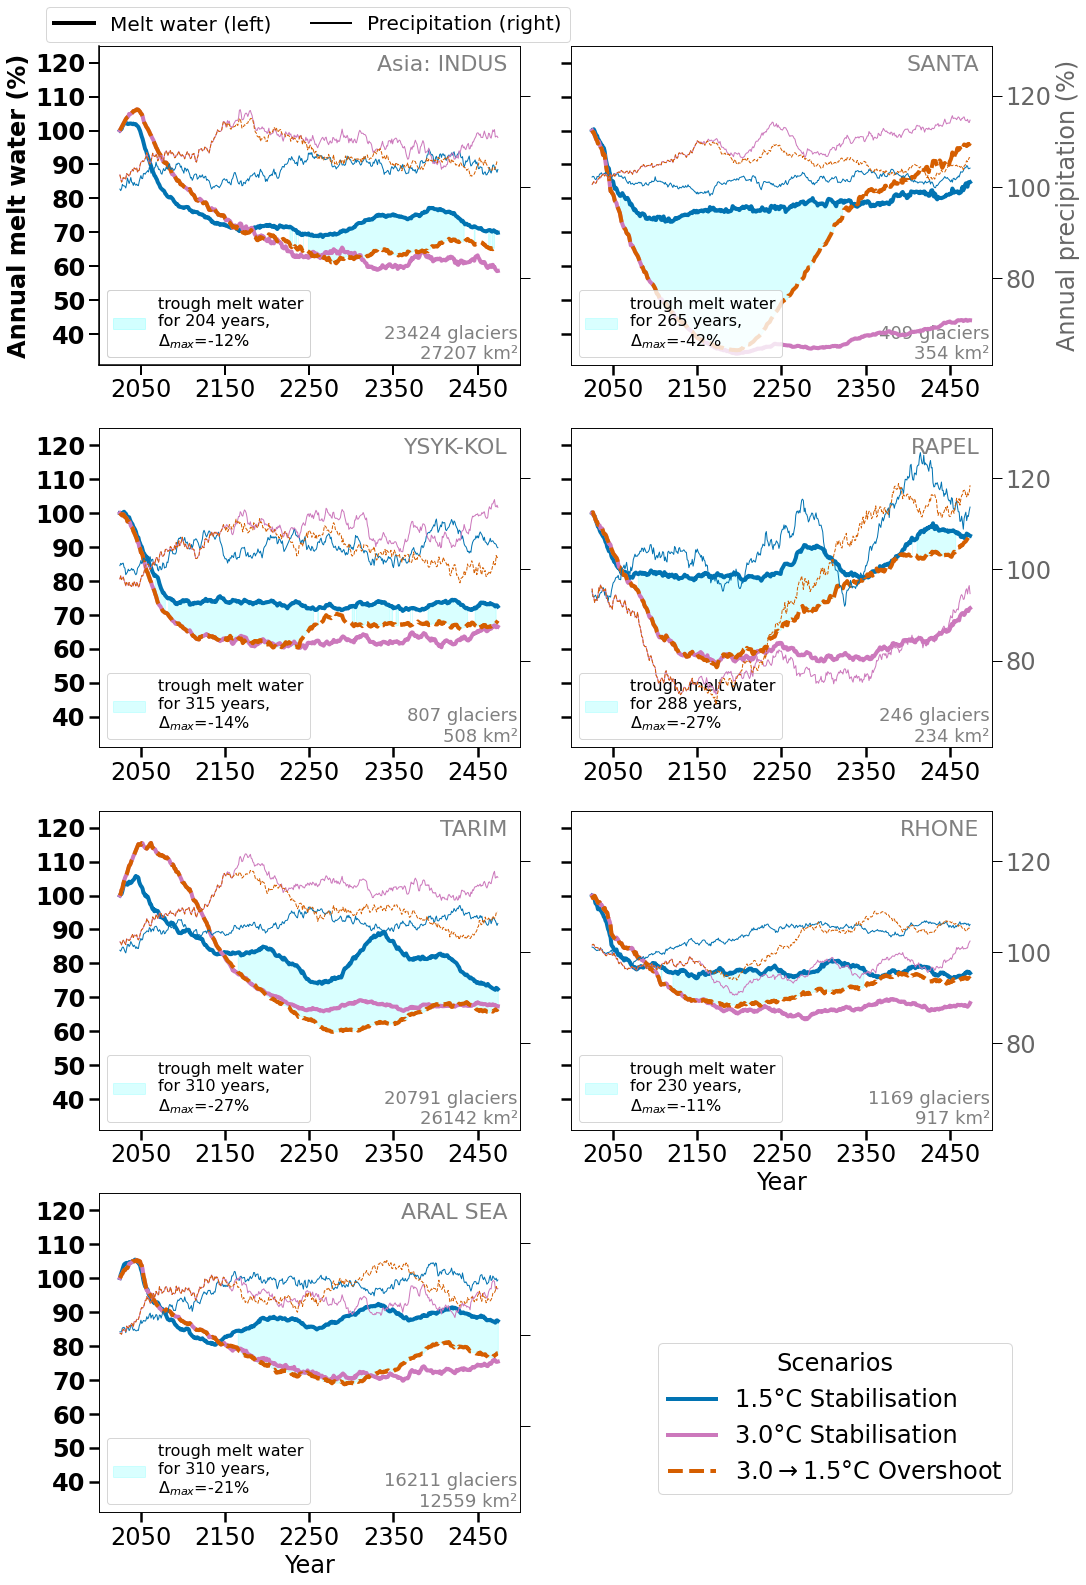

In [44]:
pd_melt_off_on_scenario_rel_basin['stab_vs_oversh'] = 'oversh'
pd_melt_off_on_scenario_rel_basin.loc[pd_melt_off_on_scenario_rel_basin['scenario'].apply(lambda x: 'stab' in x).values, 'stab_vs_oversh'] = 'stab'

var = 'precip_51yr_avg'
basins = pd_basins_arid_glac_num.MRBID.values

plt.rc('font', size=24)

plt.figure(figsize=(16,22)) #, sharey=True, sharex=True)
plt.subplot(4,2,1)
ax = plt.gca()

ax.set_ylabel('Annual melt water (%)', weight='bold') #relative to 2000-2050)'

basin = basins[0]
basin_n = pd_basin_num.loc[pd_basin_num.MRBID==int(basin)]['RIVER_BASI'].values[0]#.split()#[0]
n_glaciers = pd_basins_arid_glac_num.loc[pd_basins_arid_glac_num.MRBID==int(basin), 'n glaciers'].values[0]
glac_area = int(pd_basins_arid_glac_num.loc[pd_basins_arid_glac_num.MRBID==int(basin), 'RGI_AREA'].values.round(0))
continent_n = pd_basin_num.loc[pd_basin_num.MRBID==int(basin)]['CONTINENT'].values[0]#.split()#[0]
basin_name = f'{continent_n}: {basin_n}'
#ax.set_title(basin_name)
sns.lineplot(data=pd_melt_off_on_scenario_rel_basin.loc[pd_melt_off_on_scenario_rel_basin.basin == str(basin)],
             hue='scenario', x='time', y= 'melt_off_on_rel_2000_2050_%', 
             palette=list_color_scenario_poster_new_order,
             style = 'stab_vs_oversh',
             style_order=['stab', 'oversh'],
             hue_order=scenarios,lw=4, legend=True,
             ax = ax)
#ax.set_xlabel('Year')
#ax.grid(axis='x')
ax.set_yticks(ticks=np.arange(0,150,10),
              labels=np.arange(0,150,10), weight='bold')

for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)

# set the parameters for both axis: label size in font points, the line tick line 
# width and length in pixels
ax.tick_params(axis='both', which='major', width=2, length=10)
ax2 = ax.twinx()  
for scenario in scenarios:
    pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
    pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'basin_{basin}_glacier']
    pd_clim_scenario_g.index = pd_clim_scenario_g.year
    temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
    if var == 'temp_20yr_avg':
        var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
    else:
        var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g

    ax2.plot(pd_clim_scenario_g.year,
             var_g_to_ref,
             alpha = 1, 
             ls = scenario_ls[scenario],
             lw=1, color = color_scenario[scenario], label=label_scenario[scenario])
ax2.set_ylabel('')
if var != 'temp_20yr_avg':
    ticks = np.arange(80,131,20)
    ax2.set_yticks(ticks=ticks,
                    labels=ticks, alpha=0.6) 
else:
    ax2.set_yticks(ticks=[0,1,2,3,4,5],
               labels=[0,1,2,3,4,5], alpha=0.6)

plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)
ax.set_xlabel('')
ax.set_xlim([2000,2500])
ax2.set_xlim([2000,2500])
ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])

ax.set_ylim([31,125]);
ax2.set_ylim([61,131]);


### add legends
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
handles_2, labels_2 = ax2.get_legend_handles_labels()
leg = ax.legend(handles[:len(scenarios)], labels_2[:len(scenarios)], #title='Scenarios',
                fontsize=20, title_fontsize=22,loc = 'lower left', bbox_to_anchor=(-0.02,1.11), ncol=3)
for l in leg.get_lines():
    l.set_linewidth(4)
    

leg2 = ax.legend([handles[1], handles_2[0]], ['Melt water (left)',
                                              f'Precipitation (right)'], #changes
                 loc='lower left', fontsize=20, bbox_to_anchor=(-0.15,0.98), ncol=2)
leg2.get_lines()[0].set_linewidth(4)
leg2.get_lines()[1].set_linewidth(2)
for l in leg2.get_lines():
    l.set_color('black')
# let's not show again the legend ...
#ax.add_artist(leg)

plt.text(0.97,0.97, basin_name,
             transform=ax.transAxes,ha='right',va='top',
             color='grey', fontsize=22, zorder=-1)

plt.text(0.995,0.005, f'{n_glaciers} glaciers\n{glac_area} km²',
     transform=ax.transAxes,ha='right',va='bottom',
     color='grey', fontsize=18, zorder=-1)

########
y0,y1 = melt_water_trough_stats_basins['melt_trough_water_pot_start_end'].loc[str(basin)].split('_')
pd_basin_sel = pd_melt_off_on_scenario_rel_basin.loc[pd_melt_off_on_scenario_rel_basin.basin == str(basin)].dropna()
pd_basin_sel_stab_T15_melt_off_on = pd_basin_sel.loc[pd_basin_sel.scenario=='stab_T15'] #['runoff_rel_2000_2050_%']
pd_basin_sel_stab_T15_melt_off_on.index = pd_basin_sel_stab_T15_melt_off_on.time
pd_basin_sel_oversh_T30OS15_melt_off_on = pd_basin_sel.loc[pd_basin_sel.scenario=='oversh_T30OS15'] #['runoff_rel_2000_2050_%']
pd_basin_sel_oversh_T30OS15_melt_off_on.index = pd_basin_sel_oversh_T30OS15_melt_off_on.time

nyears,water_trough_max_diff  = melt_water_trough_stats_basins[['yrs_with_melt_trough_water',
                                                    'melt_trough_water_max_diff']].loc[str(basin)]

water_trough_max_diff = np.round(float(water_trough_max_diff),0)
add_label = f'for {int(nyears)} years,\n' + r'$\Delta_{max}$=-'+f'{int(water_trough_max_diff)}%'
condi_5perc = (pd_basin_sel_oversh_T30OS15_melt_off_on['melt_off_on_rel_2000_2050_%']-pd_basin_sel_stab_T15_melt_off_on['melt_off_on_rel_2000_2050_%']).loc[float(y0):float(y1)+1]<=-5
# pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'].where(condi_5perc)
# important -> keep the NaNs to show the potential incontinuoties ... 
ax.fill_between(pd_basin_sel_stab_T15_melt_off_on.loc[float(y0):float(y1)+1].time.where(condi_5perc),  
                 pd_basin_sel_stab_T15_melt_off_on.loc[float(y0):float(y1)+1]['melt_off_on_rel_2000_2050_%'].where(condi_5perc), 
                 pd_basin_sel_oversh_T30OS15_melt_off_on.loc[float(y0):float(y1)+1]['melt_off_on_rel_2000_2050_%'].where(condi_5perc),
                 alpha = 0.15, color='cyan', zorder=-1, label='trough melt water\n'+add_label)

handles_x, labels_x = ax.get_legend_handles_labels()
leg3 = ax.legend([handles_x[-1]], [labels_x[-1]], loc='lower left',fontsize=16)
ax.add_artist(leg3)
ax.add_artist(leg2)

axs = []
axs2 = []
for j, basin in enumerate(basins[1:]):
    basin_n = pd_basin_num.loc[pd_basin_num.MRBID==int(basin)]['RIVER_BASI'].values[0]#.split()[0]
    n_glaciers = pd_basins_arid_glac_num.loc[pd_basins_arid_glac_num.MRBID==int(basin), 'n glaciers'].values[0]
    glac_area = int(pd_basins_arid_glac_num.loc[pd_basins_arid_glac_num.MRBID==int(basin), 'RGI_AREA'].values.round(0))

    if basin_n=='TARIM HE (also TALIMU HE)':
        basin_n = 'TARIM'
    elif basin_n =='YSYK-KOL (also ISSYK-KUL)':
        basin_n = 'YSYK-KOL'
    #continent_n = pd_basin_num.loc[pd_basin_num.MRBID==int(basin)]['CONTINENT'].values[0]#.split()#[0]
    basin_name = f'{basin_n}'
    plt.subplot(4,2,j+2)
    x_j = np.arange(1,20,2)
    x2_j = np.arange(0,20,2)

    ax = plt.gca()
    basin_melt_off_on_sel = pd_melt_off_on_scenario_rel_basin.loc[pd_melt_off_on_scenario_rel_basin.basin == str(basin)]
    sns.lineplot(data=basin_melt_off_on_sel,
             hue='scenario', x='time', y= 'melt_off_on_rel_2000_2050_%',  
             palette=list_color_scenario_poster_new_order,
             style = 'stab_vs_oversh',
             style_order=['stab', 'oversh'],
             hue_order=scenarios,lw=4, legend=False,
             ax = ax)

    #ax.set_title(f'{Preg}: {basin}')

    plt.text(0.97,0.97, basin_name,
             transform=ax.transAxes,ha='right',va='top',
             color='grey', fontsize=22, zorder=-1)
    plt.text(0.995,0.005, f'{n_glaciers} glaciers\n{glac_area} km²',
     transform=ax.transAxes,ha='right',va='bottom',
     color='grey', fontsize=18, zorder=-1)

    if j in x_j:
        plt.ylabel(f'annual melt water\n(% relative to 2000-2050)', weight='bold')
        ax.set_yticks(ticks=np.arange(0,150,10),
                   labels=np.arange(0,150,10), weight='bold')
    else:
        plt.ylabel('')
        ax.set_yticks(ticks=np.arange(0,150,10),
                   labels=np.arange(0,150,10), alpha=0, fontsize=1) #visible=False) 
        #plt.setp(ax.get_yticklabels(), visible=False)

    #ax.set_ylim([70,1439.9]);


    ax.tick_params(axis='both', which='major', width=2.5, length=10)
    ax2 = ax.twinx()  
    for scenario in scenarios:
                    #'stab_T30']:

        pd_clim_scenario = pd_clim_all.loc[pd_clim_all.scenario==scenario]
        pd_clim_scenario_g = pd_clim_scenario.loc[pd_clim_scenario.region == f'basin_{basin}_glacier']
        pd_clim_scenario_g.index = pd_clim_scenario_g.year
        temp_ref_g, precip_ref_g = pd_clim_scenario_g.loc[2000:2019][['temp','precip']].mean()
        if var == 'temp_20yr_avg':
            var_g_to_ref = pd_clim_scenario_g[var] - temp_ref_g
        else:
            var_g_to_ref = 100*pd_clim_scenario_g[var]/precip_ref_g
        ax2.plot(pd_clim_scenario_g.year,
                 var_g_to_ref,
                 alpha = 1, 
                 ls = scenario_ls[scenario],
                 lw=1, color = color_scenario[scenario], label=label_scenario[scenario])
    if var != 'temp_20yr_avg':
        ticks = np.arange(80,131,20)
        ax2.set_yticks(ticks=ticks,
                        labels=ticks, alpha=0.6)  
        ylabel = 'Annual precipitation (%)' # relative to 2000-2019)' #, glacier-area weighted)'

    else:
        ax2.set_yticks(ticks=[0,1,2,3,4,5],
                   labels=[0,1,2,3,4,5], alpha=0.6)
        ylabel = r'$\Delta$T'+'(°C) relative to 2000-2019\n(glacier-area weighted)'

    if j in x2_j:
        ax2.set_ylabel(ylabel,
                      alpha = 0.6)
        #ax2.set_yticks(labels=[0,1,2,3,4], alpha=0.6)
    else:
        ax2.set_ylabel('')
        #ax2.set_yticks([])
        plt.setp(ax2.get_yticklabels(), visible=False, fontsize=1)

    #ax2.set_ylim([-0.9,5.9]);

    if j >6:
        ax.set_xlabel('Year')
    else:
        ax.set_xlabel('')
    ax.set_xlim([2000,2500])
    ax.set_xticks([2050,2150,2250,2350,2450],[2050,2150,2250,2350,2450])
    ax2.set_xlim([2000,2500])
    ax2.tick_params(axis='both', which='major', width=1, length=10, grid_alpha =0.6)
    ax.set_ylim([31,125]);
    ax2.set_ylim([61,131]);

    try:
        y0,y1 = melt_water_trough_stats_basins['melt_trough_water_pot_start_end'].loc[str(basin)].split('_')
        pd_basin_sel = pd_melt_off_on_scenario_rel_basin.loc[pd_melt_off_on_scenario_rel_basin.basin == str(basin)].dropna()
        pd_basin_sel_stab_T15_melt_off_on = pd_basin_sel.loc[pd_basin_sel.scenario=='stab_T15'] #['runoff_rel_2000_2050_%']
        pd_basin_sel_stab_T15_melt_off_on.index = pd_basin_sel_stab_T15_melt_off_on.time
        pd_basin_sel_oversh_T30OS15_melt_off_on = pd_basin_sel.loc[pd_basin_sel.scenario=='oversh_T30OS15'] #['runoff_rel_2000_2050_%']
        pd_basin_sel_oversh_T30OS15_melt_off_on.index = pd_basin_sel_oversh_T30OS15_melt_off_on.time

        nyears,water_trough_max_diff  = melt_water_trough_stats_basins[['yrs_with_melt_trough_water',
                                                            'melt_trough_water_max_diff']].loc[str(basin)]

        water_trough_max_diff = np.round(float(water_trough_max_diff),0)
        add_label = f'for {int(nyears)} years,\n' + r'$\Delta_{max}$=-'+f'{int(water_trough_max_diff)}%'
        condi_5perc = (pd_basin_sel_oversh_T30OS15_melt_off_on['melt_off_on_rel_2000_2050_%']-pd_basin_sel_stab_T15_melt_off_on['melt_off_on_rel_2000_2050_%']).loc[float(y0):float(y1)+1]<=-5
        # pd_basin_sel_oversh_T30OS15_runoff.loc[float(y0):float(y1)+1]['runoff_dry3m_rel_2000_2050_%'].where(condi_5perc)
        # important -> keep the NaNs to show the potential incontinuoties ... 
        ax.fill_between(pd_basin_sel_stab_T15_melt_off_on.loc[float(y0):float(y1)+1].time.where(condi_5perc),  
                         pd_basin_sel_stab_T15_melt_off_on.loc[float(y0):float(y1)+1]['melt_off_on_rel_2000_2050_%'].where(condi_5perc), 
                         pd_basin_sel_oversh_T30OS15_melt_off_on.loc[float(y0):float(y1)+1]['melt_off_on_rel_2000_2050_%'].where(condi_5perc),
                         alpha = 0.15, color='cyan', zorder=-1, label='trough melt water\n'+add_label)
        leg_t = ax.legend(loc='lower left', fontsize=16)        

        add_normal_trough_water = False
        if add_normal_trough_water:
            y0,y1 = water_trough_stats_basins['water_trough_start_end'].loc[str(basin)].split('_')
            pd_basin_sel = pd_melt_off_on_scenario_rel_basin.loc[pd_melt_off_on_scenario_rel_basin.basin == str(basin)].dropna()
            pd_basin_sel_stab_T15_melt_off_on = pd_basin_sel.loc[pd_basin_sel.scenario=='stab_T15'] #['runoff_rel_2000_2050_%']
            pd_basin_sel_stab_T15_melt_off_on.index = pd_basin_sel_stab_T15_melt_off_on.time
            pd_basin_sel_oversh_T30OS15_melt_off_on = pd_basin_sel.loc[pd_basin_sel.scenario=='oversh_T30OS15'] #['runoff_rel_2000_2050_%']
            pd_basin_sel_oversh_T30OS15_melt_off_on.index = pd_basin_sel_oversh_T30OS15_melt_off_on.time

            nyears,water_trough_max_diff  = water_trough_stats_basins[['yrs_with_water_trough',
                                                                'water_trough_max_diff']].loc[str(basin)]

            water_trough_max_diff = np.round(float(water_trough_max_diff),0)
            add_label = f'for {int(nyears)} years,\n' + r'$\Delta_{max}$=-'+f'{int(water_trough_max_diff)}%'
            ax.fill_between(pd_basin_sel_stab_T15_melt_off_on.loc[float(y0):float(y1)+1].time, 
                             pd_basin_sel_stab_T15_melt_off_on.loc[float(y0):float(y1)+1]['melt_off_on_rel_2000_2050_%'], 
                             pd_basin_sel_oversh_T30OS15_melt_off_on.loc[float(y0):float(y1)+1]['melt_off_on_rel_2000_2050_%'],
                             alpha = 0.1, color='cyan', zorder=-1, label='trough water\n'+add_label)
        #if basin_n == 'RAPEL':
        #else:
        #ax.legend(loc='lower left', fontsize=20)
    except:
        print(f'no trough water: {basin}')
    axs.append(ax)
    axs2.append(ax2)
axs[0].set_title('blub')
plt.tight_layout()


from matplotlib.lines import Line2D
lines = []
#for k in color_scenario_poster.keys():
#    line = Line2D([0], [0], label=label_scenario[k], color=color_scenario_poster[k], lw=4)
#    lines.append(line)
for k in scenarios:
    line = Line2D([0], [0], ls=scenario_ls[k], label=label_scenario[k], color=color_scenario_poster[k], lw=4)
    lines.append(line)
axs[-2].set_xlabel('Year')
ax.legend(handles=lines, loc = 'lower left', bbox_to_anchor=(1.3,0.02), title = 'Scenarios')
ax.add_artist(leg_t)
    
    
axs[-2].set_xlabel('Year')
axs[-1].set_xlabel('Year')

for axi in axs[1:]:
    axi.set_ylabel('')
for ax2i in axs2[1:]:
    ax2i.set_ylabel('')
axs[0].set_title('')
plt.savefig(f'../figures/3_suppl_fig_most_arid_glaciated_basin_51yr_avg_melt_off_on_{bc}_vs_prcp_precip_51yr_avg.png')
plt.savefig(f'../figures/3_suppl_fig_most_arid_glaciated_basin_51yr_avg_melt_off_on_{bc}_vs_prcp_precip_51yr_avg.pdf')


## ***Some comparisons to precipitation effects*** (now again for all basins and looking at annual runoff)

In [45]:
basin_glac_ind = pd_basin_num.where(pd_basin_num['RGI_AREA'] / pd_basin_num['AREA_CALC']> 0.001).dropna(how='all').MRBID.astype(int).astype(str).values
water_trough_stats_basins_sel = water_trough_stats_basins.loc[basin_glac_ind].copy()

In [46]:
len(water_trough_stats_basins_sel.where(condi_vol_diff).dropna(how='all'))

56

In [47]:
len(water_trough_stats_basins_sel.where(condi_vol_diff& condi_after_2150).dropna(how='all'))

46

In [48]:
len(water_trough_stats_basins_sel.where(condi_trough).dropna(how='all'))

32

In [49]:
water_trough_stats_basins.corr_coef_oversh_temp_precip

4110    0.829802
4123    0.818637
4125    0.201568
4401    0.829818
4406    0.455459
          ...   
3423   -0.881893
3426    0.481697
3428   -0.794695
3429   -0.780485
5406    0.623385
Name: corr_coef_oversh_temp_precip, Length: 75, dtype: float64

In [50]:
len(water_trough_stats_basins_sel.dropna(how='all'))

60

In [51]:
condi_slope_clear = water_trough_stats_basins.corr_coef_oversh_temp_precip**2>0.3
condi_slope_pos = water_trough_stats_basins['slope_oversh_temp_precip'] > 10  # 3% increase on average between 2050 and 2350
condi_slope_neg = water_trough_stats_basins['slope_oversh_temp_precip'] < -10

print(len(water_trough_stats_basins_sel.where(condi_vol_diff & condi_slope_pos& condi_slope_clear).dropna()), len(water_trough_stats_basins_sel.where(condi_vol_diff & condi_slope_neg& condi_slope_clear).dropna()))

9 15


In [52]:
# precipitation decreases with increasing temperatures 
water_trough_stats_basins_sel.where(condi_trough& condi_slope_clear).dropna().where(water_trough_stats_basins_sel.where(condi_trough& condi_slope_clear).dropna()['slope_oversh_temp_precip']<0)['trough_water_max_diff'].quantile([0.25,0.5,0.75])

0.25    12.875462
0.50    16.772171
0.75    22.947390
Name: trough_water_max_diff, dtype: float64

In [53]:
# precipitation increases with increasing temperatures 
water_trough_stats_basins_sel.where(condi_trough& condi_slope_clear).dropna().where(water_trough_stats_basins_sel.where(condi_trough& condi_slope_clear).dropna()['slope_oversh_temp_precip']>0)['trough_water_max_diff'].quantile([0.25,0.5,0.75])

0.25     8.715115
0.50     9.731586
0.75    14.813953
Name: trough_water_max_diff, dtype: float64

In [54]:
len(water_trough_stats_basins_sel.where(condi_slope_clear).dropna())

25

12
17
32


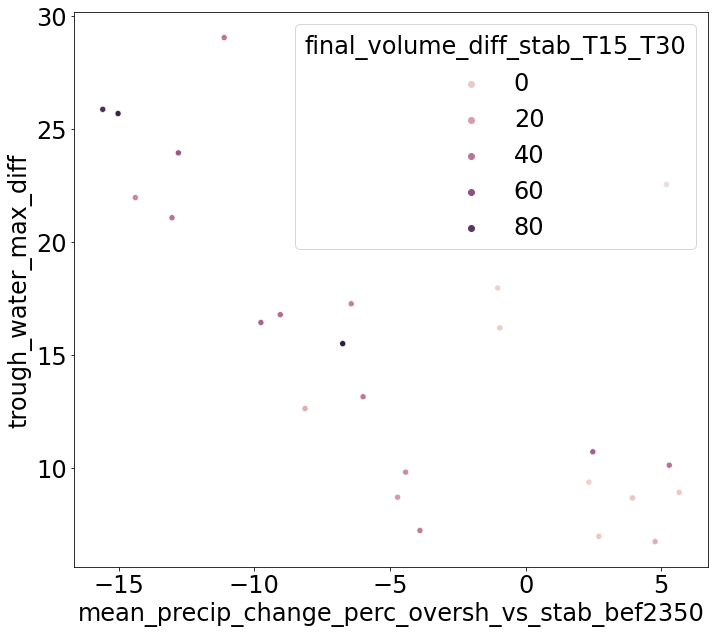

In [55]:
plt.figure(figsize=(25,10))
plt.subplot(121)
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_slope_clear).dropna(),
                y='trough_water_max_diff',
                x='mean_precip_change_perc_oversh_vs_stab_bef2350',
                color='red', hue= 'final_volume_diff_stab_T15_T30') #, label=f'{n} basins  with >1% avg. precipitation decrease\nin period 2050-2350 for Overshoot 3.0°C->1.5°C\ncompared to 1.5°C stabilisation scenario') 

condi_prcp_increase = water_trough_stats_basins['mean_precip_change_perc_oversh_vs_stab_bef2350'] > 1  # 3% increase on average between 2050 and 2350
condi_prcp_decrease = water_trough_stats_basins['mean_precip_change_perc_oversh_vs_stab_bef2350'] < -1

print(len(water_trough_stats_basins_sel.where(condi_vol_diff & condi_prcp_increase).dropna()))
print(len(water_trough_stats_basins_sel.where(condi_vol_diff &  condi_prcp_decrease).dropna()))
print(len(water_trough_stats_basins_sel.trough_water_max_diff.dropna()))

In [56]:
water_trough_stats_basins_sel['trough_water_max_diff_no_NaNs'] = water_trough_stats_basins_sel['trough_water_max_diff'].copy()
water_trough_stats_basins_sel['yrs_with_trough_water_no_NaNs'] = water_trough_stats_basins_sel['yrs_with_trough_water'].copy()

water_trough_stats_basins_sel['cumulative_runoff_diff_trough_no_NaNs'] = water_trough_stats_basins_sel['cumulative_runoff_diff_trough'].astype(float)
water_trough_stats_basins_sel.loc[water_trough_stats_basins_sel.trough_water_max_diff_no_NaNs.isna(),'trough_water_max_diff_no_NaNs'] = 0
water_trough_stats_basins_sel.loc[water_trough_stats_basins_sel.yrs_with_trough_water_no_NaNs.isna(),'yrs_with_trough_water_no_NaNs'] = 0

water_trough_stats_basins_sel.loc[water_trough_stats_basins_sel.cumulative_runoff_diff_trough_no_NaNs.isna(),'cumulative_runoff_diff_trough_no_NaNs'] = 0


In [57]:
len(water_trough_stats_basins_sel.where(water_trough_stats_basins_sel['trough_water_max_diff_no_NaNs'].dropna()>0).dropna(how='all'))

32

In [58]:
len(water_trough_stats_basins_sel)

60

31 24
31 24
46


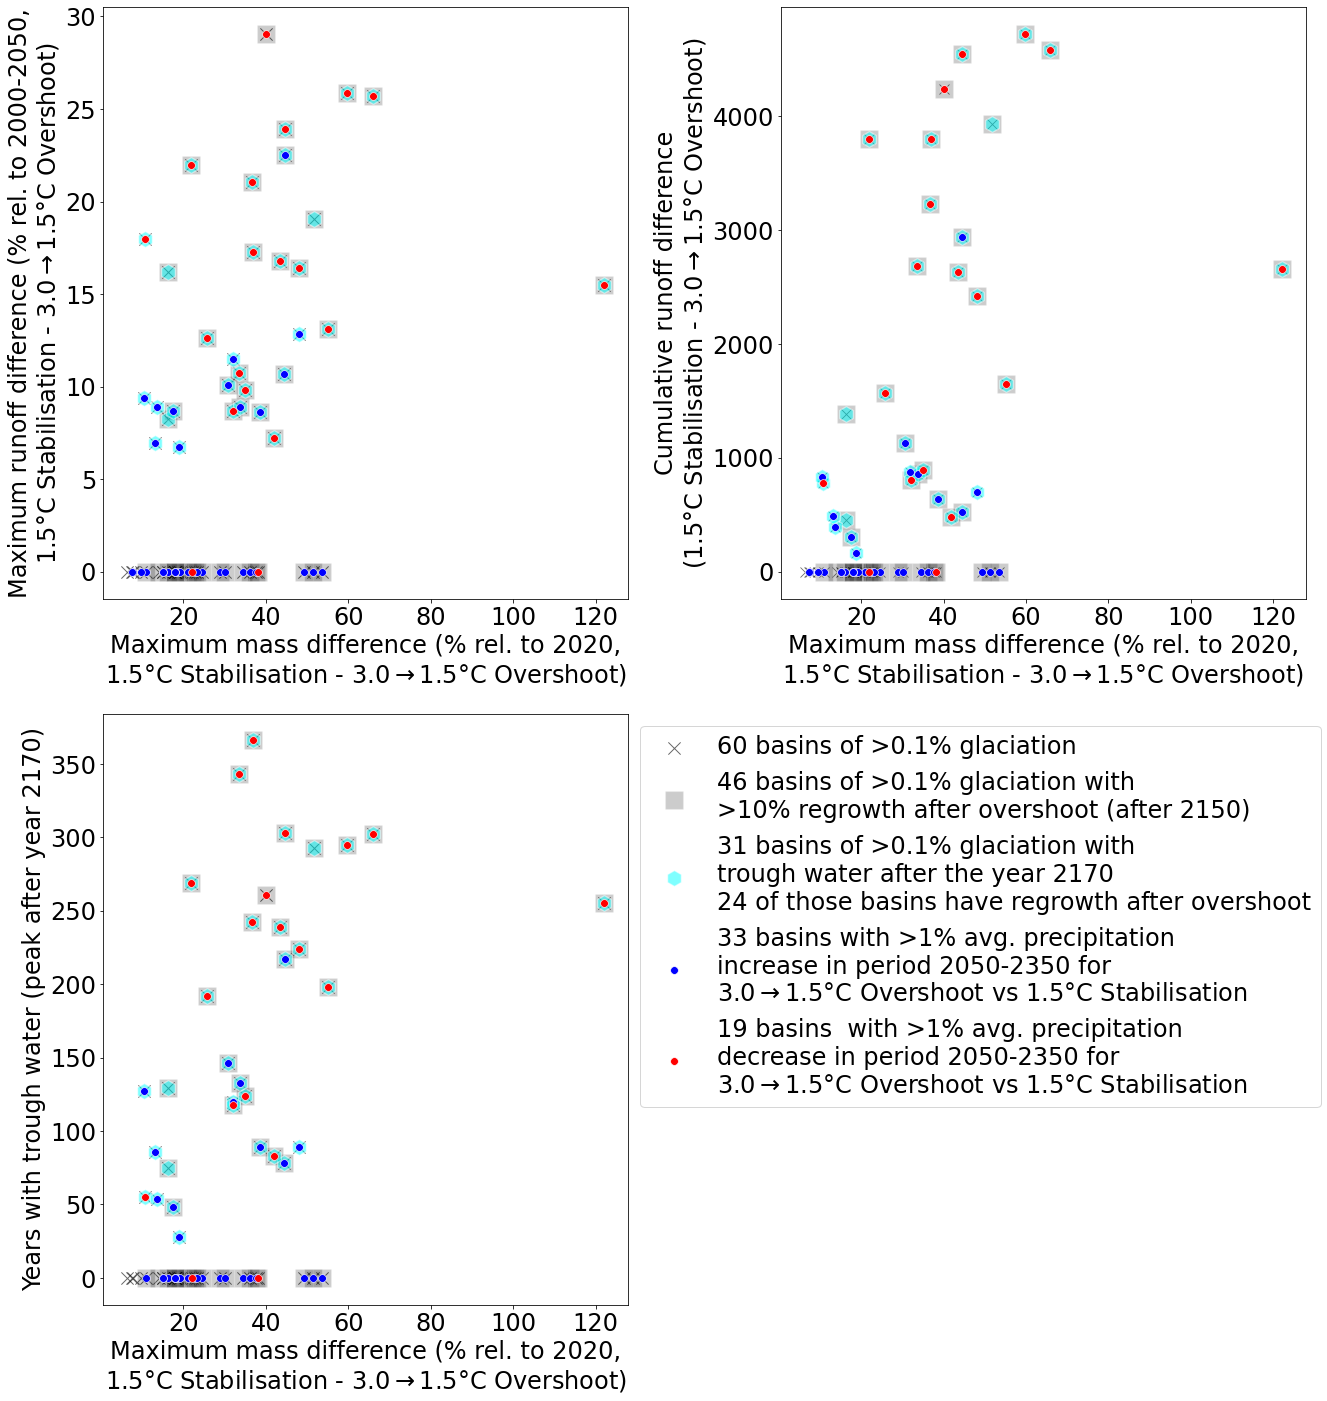

In [59]:
plt.figure(figsize=(20,20))

condi_prcp_increase = water_trough_stats_basins_sel['mean_precip_change_perc_oversh_vs_stab_bef2350'] > 1  # 3% increase on average between 2050 and 2350
condi_prcp_decrease = water_trough_stats_basins_sel['mean_precip_change_perc_oversh_vs_stab_bef2350'] < -1
plt.subplot(221)
x = 'max_volume_diff_perc_stab_T15_vs_oversh30'
y = 'trough_water_max_diff_no_NaNs'
n=len(water_trough_stats_basins_sel[[y,x]].dropna(how='all'))
sns.scatterplot(data = water_trough_stats_basins_sel[[y,x]].dropna(how='all'), #.where(condi_trough).dropna(),
                y=y, x=x, color='black', 
                alpha = 0.6, marker='x', s= 150,
                label=f'{n} basins of >0.1% glaciation') #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)

n=len(water_trough_stats_basins_sel.where(condi_vol_diff&condi_after_2150)[[y,x]].dropna(how='all'))
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_vol_diff&condi_after_2150)[[y,x]].dropna(how='all'), #.where(condi_trough).dropna(),
                y=y, x=x, color='black', 
                alpha = 0.2, marker='s', s= 300,
                label=f'{n} basins of >0.1% glaciation with\n>10% regrowth after 2150') #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)


n=len(water_trough_stats_basins_sel.where(condi_trough  & condi_water_trough_2170)[[y,x]].dropna(how='all'))
n2=len(water_trough_stats_basins_sel.where(condi_trough  & condi_water_trough_2170& condi_after_2150 & condi_vol_diff)[[y,x]].dropna(how='all'))
print(n,n2)

sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_trough  & condi_water_trough_2170)[[y,x]].dropna(how='all'), #.where(condi_trough).dropna(),
                y=y, x=x, color='cyan', 
                alpha = 0.5, marker='h', s= 250,
                label=f'{n} basins of >0.1% glaciation with\ntrough water after the year 2170\n{n2} of those basins have regrowth after overshoot') #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)


n=len(water_trough_stats_basins_sel.where(condi_prcp_increase)[[y,x]].dropna(how='all'))
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_prcp_increase)[[y,x]].dropna(how='all'),
                y=y, x=x,s=60,
                 color='blue',
                label=f'{n} basins with >1% avg. precipitation\nincrease in period 2050-2350 for\n'+r'3.0$\rightarrow$1.5°C Overshoot vs 1.5°C Stabilisation')  #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)

n=len(water_trough_stats_basins_sel.where(condi_prcp_decrease)[[y,x]].dropna(how='all'))
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_prcp_decrease)[[y,x]].dropna(how='all'),
                y=y, x=x, s= 60,
                color='red', label=f'{n} basins  with >1% avg. precipitation\ndecrease in period 2050-2350 for\n'+r'3.0$\rightarrow$1.5°C Overshoot vs 1.5°C Stabilisation') 
leg = plt.legend(fontsize=18)
leg.remove()
plt.ylabel('Maximum runoff difference (% rel. to 2000-2050,\n'+r'1.5°C Stabilisation - 3.0$\rightarrow$1.5°C Overshoot)')
plt.xlabel('Maximum mass difference (% rel. to 2020,\n'+r'1.5°C Stabilisation - 3.0$\rightarrow$1.5°C Overshoot)')


plt.subplot(222)
x = 'max_volume_diff_perc_stab_T15_vs_oversh30'
y = 'cumulative_runoff_diff_trough_no_NaNs'
n=len(water_trough_stats_basins_sel[[y,x]].dropna(how='all'))
sns.scatterplot(data = water_trough_stats_basins_sel[[y,x]].dropna(how='all'), #.where(condi_trough).dropna(),
                y=y, x=x, color='black', 
                alpha = 0.6, marker='x', s= 100,
                label=f'{n} basins of >0.1% glaciation') #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)

n=len(water_trough_stats_basins_sel.where(condi_vol_diff&condi_after_2150)[[y,x]].dropna(how='all'))
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_vol_diff&condi_after_2150)[[y,x]].dropna(how='all'), #.where(condi_trough).dropna(),
                y=y, x=x, color='black', 
                alpha = 0.2, marker='s', s= 300,
                label=f'{n} basins of >0.1% glaciation with\n>10% regrowth after 2150') #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)



n=len(water_trough_stats_basins_sel.where(condi_trough  & condi_water_trough_2170)[[y,x]].dropna(how='all'))
n2=len(water_trough_stats_basins_sel.where(condi_trough  & condi_water_trough_2170& condi_after_2150 & condi_vol_diff)[[y,x]].dropna(how='all'))
print(n,n2)
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_trough  & condi_water_trough_2170)[['cumulative_runoff_diff_trough_no_NaNs','max_volume_diff_perc_stab_T15_vs_oversh30']].dropna(how='all'), #.where(condi_trough).dropna(),
               y=y, x=x, color='cyan', 
                alpha = 0.5, marker='h', s= 250,
                label=f'{n} basins of >0.1% glaciation with\ntrough water after the year 2170\n{n2} of those basins have regrowth after overshoot') #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)


n=len(water_trough_stats_basins_sel.where(condi_prcp_increase)[[y,x]].dropna(how='all'))
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_prcp_increase)[[y,x]].dropna(how='all'),
                y=y, x=x,s=60,
                color='blue', label=f'{n} basins with >1% avg. precipitation\nincrease in period 2050-2350 for\n'+r'3.0$\rightarrow$1.5°C Overshoot vs 1.5°C Stabilisation')  #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)

n=len(water_trough_stats_basins_sel.where(condi_prcp_decrease)[[y,x]].dropna(how='all'))
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_prcp_decrease)[[y,x]].dropna(how='all'),
                y=y, x=x, s= 60,
                color='red', label=f'{n} basins  with >1% avg. precipitation\ndecrease in period 2050-2350 for\nOvershoot 3.0°C->1.5°C vs 1.5°C Stabilisation') 
leg = plt.legend(fontsize=18)
leg.remove()
plt.ylabel('Cumulative runoff difference\n'+r'(1.5°C Stabilisation - 3.0$\rightarrow$1.5°C Overshoot)')
plt.xlabel('Maximum mass difference (% rel. to 2020,\n'+r'1.5°C Stabilisation - 3.0$\rightarrow$1.5°C Overshoot)')


plt.subplot(223)
x = 'max_volume_diff_perc_stab_T15_vs_oversh30'
y = 'yrs_with_trough_water_no_NaNs'
n=len(water_trough_stats_basins_sel[[y,x]].dropna(how='all'))
sns.scatterplot(data = water_trough_stats_basins_sel[[y,x]].dropna(how='all'), #.where(condi_trough).dropna(),
                y=y, x=x, color='black', 
                alpha = 0.6, marker='x', s= 150,
                label=f'{n} basins of >0.1% glaciation') #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)

n=len(water_trough_stats_basins_sel.where(condi_vol_diff&condi_after_2150)[[y,x]].dropna(how='all'))
print(n)
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_vol_diff&condi_after_2150)[[y,x]].dropna(how='all'), #.where(condi_trough).dropna(),
                y=y, x=x, color='black', 
                alpha = 0.2, marker='s', s= 300,
                label=f'{n} basins of >0.1% glaciation with\n>10% regrowth after overshoot (after 2150)') #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)


## all that have a trough and have at least 10%  lager glacier volume 
#print('basins that are 0.1% glaciated, and create a trough water after the year 2170:')
#print(len(water_trough_stats_basins_sel.where(condi_trough  & condi_water_trough_2170).dropna(how='all')))

# all that have a trough and have at least 10%  lager glacier volume 
#print('basins that are 0.1% glaciated, have at least a mass difference of 10% after the global overshoot and create a trough water after the year 2170:')
#print(len(water_trough_stats_basins_sel.where(condi_trough & condi_vol_diff & condi_after_2150 & condi_water_trough_2170).dropna(how='all')))

n=len(water_trough_stats_basins_sel.where(condi_trough  & condi_water_trough_2170)[[y,x]].dropna(how='all'))
n2=len(water_trough_stats_basins_sel.where(condi_trough  & condi_water_trough_2170& condi_after_2150 & condi_vol_diff)[[y,x]].dropna(how='all'))

sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_trough  & condi_water_trough_2170)[[y,x]].dropna(how='all'), #.where(condi_trough).dropna(),
                y=y, x=x,color='cyan', 
                alpha = 0.5, marker='h', s= 250,
                label=f'{n} basins of >0.1% glaciation with\ntrough water after the year 2170\n{n2} of those basins have regrowth after overshoot') #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)


n=len(water_trough_stats_basins_sel.where(condi_prcp_increase&condi_vol_diff)[[y,x]].dropna(how='all'))
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_prcp_increase&condi_vol_diff)[[y,x]].dropna(how='all'),
                y=y, x=x,s=60,
                color='blue', label=f'{n} basins with >1% avg. precipitation\nincrease in period 2050-2350 for\n'+r'3.0$\rightarrow$1.5°C Overshoot vs 1.5°C Stabilisation')  #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)

n=len(water_trough_stats_basins_sel.where(condi_prcp_decrease&condi_vol_diff)[[y,x]].dropna(how='all'))
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_prcp_decrease&condi_vol_diff)[[y,x]].dropna(how='all'),
                y=y, x=x, s= 60,
                color='red', label=f'{n} basins  with >1% avg. precipitation\ndecrease in period 2050-2350 for\n'+r'3.0$\rightarrow$1.5°C Overshoot vs 1.5°C Stabilisation') 

plt.ylabel('Years with trough water (peak after year 2170)')
plt.xlabel('Maximum mass difference (% rel. to 2020,\n'+r'1.5°C Stabilisation - 3.0$\rightarrow$1.5°C Overshoot)')
plt.tight_layout()
plt.legend(fontsize=24, bbox_to_anchor=(1,1), loc = 'upper left')
plt.savefig('../figures/3_suppl_fig_trough_water_basins_analysis.png')
plt.savefig('../figures/3_suppl_fig_trough_water_basins_analysis.pdf')

In [60]:
with open('../data/additional_data/basin_glac_cluster_fig3_dictionary.json', 'r') as json_file:
    basin_glac_clus_dict = json.load(json_file)

In [61]:
pd_basin_glac_clus = pd.DataFrame(basin_glac_clus_dict.values(), columns=['basin_glac_cluster_fig3'], index = basin_glac_clus_dict.keys())

In [62]:
water_trough_stats_basins_sel.loc[pd_basin_glac_clus.index, 'basin_glac_cluster_fig3'] = pd_basin_glac_clus.basin_glac_cluster_fig3

In [63]:
cols = sns.color_palette(['black','C8','C8','C5'])

In [64]:
water_trough_stats_basins_sel.loc[water_trough_stats_basins_sel.basin_glac_cluster_fig3 == 0]

yrs_with_trough_water cumulative_runoff_diff_trough  \
4401                    0.0                           NaN   
4408                    0.0                           NaN   
4414                    0.0                           NaN   
4416                    0.0                           NaN   
4418                    0.0                           NaN   
4428                    0.0                           NaN   
4430                    0.0                           NaN   
4431                    0.0                           NaN   
4435                    0.0                           NaN   

     trough_water_min_year  trough_water_max_diff trough_water_pot_start_end  \
4401                   NaN                    NaN                        NaN   
4408                   NaN                    NaN                        NaN   
4414                   NaN                    NaN                        NaN   
4416                   NaN                    NaN                        NaN   
4418                   NaN                    NaN                        NaN   
4428                   NaN                    NaN                        NaN   
4430                   NaN                    NaN                        NaN   
4431                   NaN                    NaN                        NaN   
4435                   NaN                    NaN                        NaN   

      peak_temp_diff_oversh_vs_stab_bef2350  \
4401                               1.763256   
4408                               2.111167   
4414                               2.607044   
4416                               2.147287   
4418                               2.692178   
4428                               2.070715   
4430                               2.526665   
4431                               2.007027   
4435                               2.176566   

      yr_peak_temp_diff_oversh_vs_stab_bef2350  regional_warming_aft2350  \
4401                                    2179.0                  0.671886   
4408                                    2179.0                  0.681674   
4414                                    2179.0                  0.680704   
4416                                    2179.0                  0.809032   
4418                                    2179.0                  0.688907   
4428                                    2179.0                  0.764599   
4430                                    2221.0                  0.665723   
4431                                    2179.0                  0.737150   
4435                                    2179.0                  0.669143   

      cumsum_temp_diff_oversh_stab_bef2350  \
4401                            219.600523   
4408                            268.601112   
4414                            338.952428   
4416                            276.580270   
4418                            342.431031   
4428                            266.572216   
4430                            332.821529   
4431                            257.851308   
4435                            284.214888   

      cumsum_temp_diff_oversh_stab_aft2350  ...  slope_oversh_temp_precip  \
4401                             22.809479  ...                120.954992   
4408                             30.377593  ...                 85.130012   
4414                             25.081157  ...                 45.618759   
4416                             25.436358  ...                113.761792   
4418                             24.291771  ...                 43.594681   
4428                             25.839203  ...                119.496792   
4430                             24.151059  ...                 39.597041   
4431                             25.639776  ...                116.105631   
4435                             27.154411  ...                 68.665628   

      max_volume_diff_perc_stab_T15_vs_oversh30  \
4401                                  10.958569   
4408                        

Text(0.5, 0, 'Maximum mass difference (% rel. to 2020,\n1.5°C Stabilisation - 3.0°C->1.5°C Overshoot)')

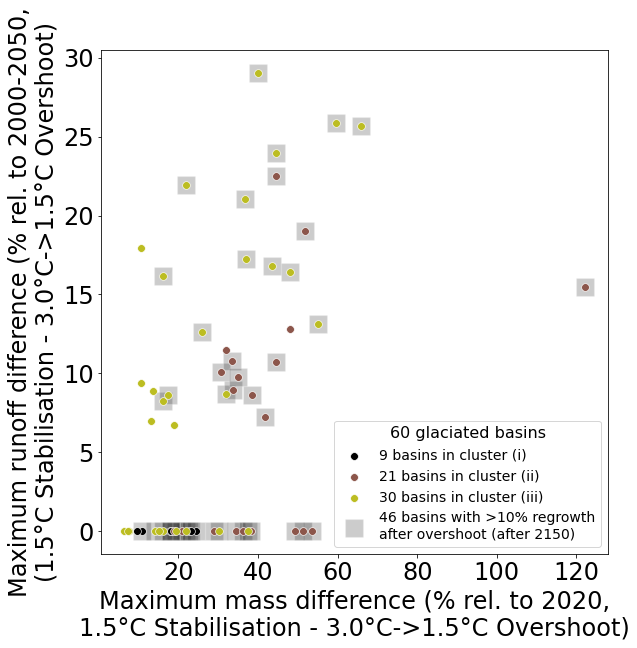

In [65]:
plt.figure(figsize=(20,20))

condi_clus_black = water_trough_stats_basins_sel['basin_glac_cluster_fig3'] == 0  # 3% increase on average between 2050 and 2350
condi_clus_yellow = (water_trough_stats_basins_sel['basin_glac_cluster_fig3'] == 1) #| (water_trough_stats_basins_sel['basin_glac_cluster_fig3'] == 2)
condi_clus_brown = water_trough_stats_basins_sel['basin_glac_cluster_fig3'] == 2

plt.subplot(221)
#n=len(water_trough_stats_basins_sel[['water_trough_max_diff_no_NaNs','max_volume_diff_perc_stab_T15_vs_oversh30']].dropna(how='all'))
#sns.scatterplot(data = water_trough_stats_basins_sel[['water_trough_max_diff_no_NaNs','max_volume_diff_perc_stab_T15_vs_oversh30']].dropna(how='all'), #.where(condi_trough).dropna(),
#                y='water_trough_max_diff_no_NaNs',
#                x='max_volume_diff_perc_stab_T15_vs_oversh30', color='black', 
#                alpha = 0.6, marker='x', s= 150,
#                label=f'{n} basins of >0.1% glaciation') #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)


n=len(water_trough_stats_basins_sel.where(condi_clus_black)[['trough_water_max_diff_no_NaNs','max_volume_diff_perc_stab_T15_vs_oversh30']].dropna(how='all'))
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_clus_black)[['trough_water_max_diff_no_NaNs','max_volume_diff_perc_stab_T15_vs_oversh30']].dropna(how='all'),
                y='trough_water_max_diff_no_NaNs',s=60,
                x='max_volume_diff_perc_stab_T15_vs_oversh30', color=cols[0],
                label = f'{n} basins in cluster (i)') #, label=f'{n} basins with >1% avg. precipitation\nincrease in period 2050-2350 for\nOvershoot 3.0°C->1.5°C vs 1.5°C Stabilisation')  #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)

n=len(water_trough_stats_basins_sel.where(condi_clus_brown)[['trough_water_max_diff_no_NaNs','max_volume_diff_perc_stab_T15_vs_oversh30']].dropna(how='all'))
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_clus_brown)[['trough_water_max_diff_no_NaNs','max_volume_diff_perc_stab_T15_vs_oversh30']].dropna(how='all'),
                y='trough_water_max_diff_no_NaNs', s= 60,
                x='max_volume_diff_perc_stab_T15_vs_oversh30',
                color=cols[-1], label = f'{n} basins in cluster (ii)') # , label=f'{n} basins  with >1% avg. precipitation\ndecrease in period 2050-2350 for\nOvershoot 3.0°C->1.5°C vs 1.5°C Stabilisation') 


n=len(water_trough_stats_basins_sel.where(condi_clus_yellow)[['trough_water_max_diff_no_NaNs','max_volume_diff_perc_stab_T15_vs_oversh30']].dropna(how='all'))
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_clus_yellow)[['trough_water_max_diff_no_NaNs','max_volume_diff_perc_stab_T15_vs_oversh30']].dropna(how='all'),
                y='trough_water_max_diff_no_NaNs', s= 60,
                x='max_volume_diff_perc_stab_T15_vs_oversh30',
                color=cols[1], label = f'{n} basins in cluster (iii)') # , label=f'{n} basins  with >1% avg. precipitation\ndecrease in period 2050-2350 for\nOvershoot 3.0°C->1.5°C vs 1.5°C Stabilisation') 


n=len(water_trough_stats_basins_sel.where(condi_vol_diff&condi_after_2150)[['trough_water_max_diff_no_NaNs','max_volume_diff_perc_stab_T15_vs_oversh30']].dropna(how='all'))
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_vol_diff&condi_after_2150)[['trough_water_max_diff_no_NaNs','max_volume_diff_perc_stab_T15_vs_oversh30']].dropna(how='all'), #.where(condi_trough).dropna(),
                y='trough_water_max_diff_no_NaNs',
                x='max_volume_diff_perc_stab_T15_vs_oversh30', color='black', 
                alpha = 0.2, marker='s', s= 300,
                label=f'{n} basins with >10% regrowth\nafter overshoot (after 2150)', zorder=-1) #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)


leg = plt.legend(title = '60 glaciated basins', fontsize=14, loc = 'lower right', title_fontsize=16)#leg.remove()
plt.ylabel('Maximum runoff difference (% rel. to 2000-2050,\n(1.5°C Stabilisation - 3.0°C->1.5°C Overshoot)')
plt.xlabel('Maximum mass difference (% rel. to 2020,\n1.5°C Stabilisation - 3.0°C->1.5°C Overshoot)')



### Decreasing vs increasing prcp analysis

12
17
32
water trough intensity ratio of decreasing vs increasing prcp basins:
1.8353683532076506


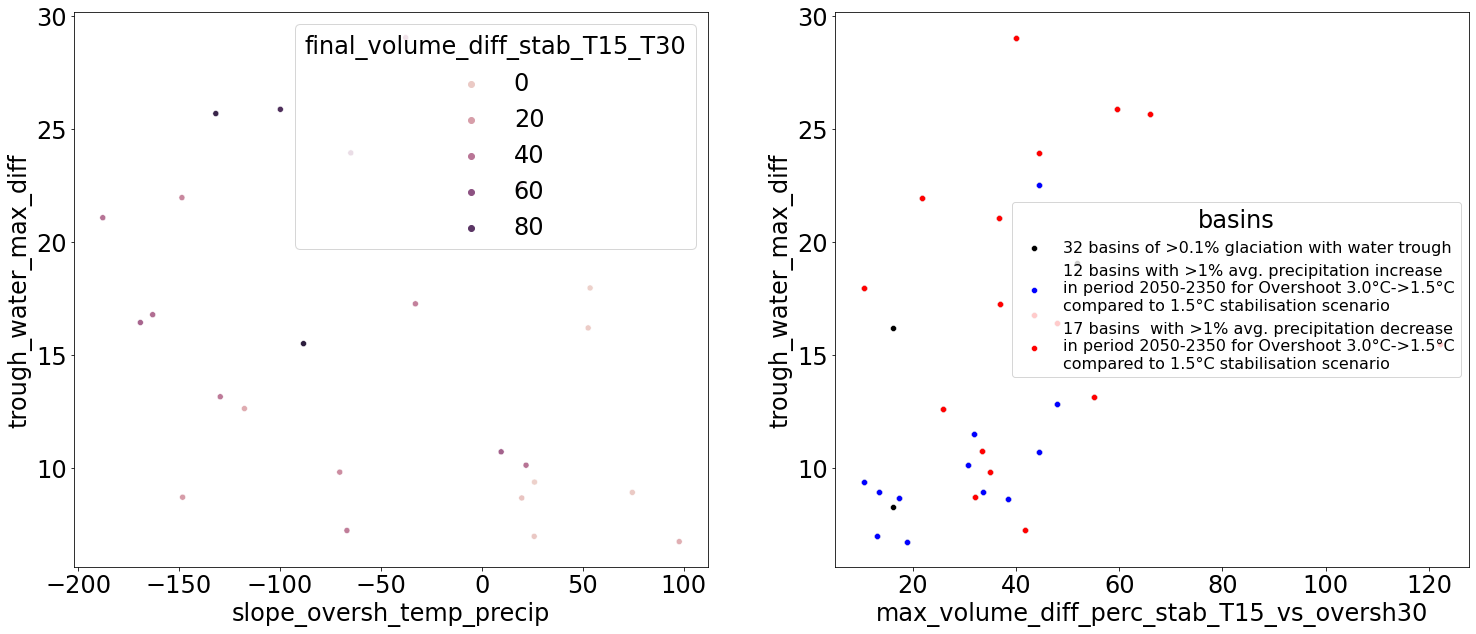

In [66]:
plt.figure(figsize=(25,10))
plt.subplot(121)
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_trough& condi_slope_clear).dropna(),
                y='trough_water_max_diff',
                x='slope_oversh_temp_precip',
                color='red', hue= 'final_volume_diff_stab_T15_T30') #, label=f'{n} basins  with >1% avg. precipitation decrease\nin period 2050-2350 for Overshoot 3.0°C->1.5°C\ncompared to 1.5°C stabilisation scenario') 

condi_prcp_increase = water_trough_stats_basins['mean_precip_change_perc_oversh_vs_stab_bef2350'] > 1  # 3% increase on average between 2050 and 2350
condi_prcp_decrease = water_trough_stats_basins['mean_precip_change_perc_oversh_vs_stab_bef2350'] < -1

print(len(water_trough_stats_basins_sel.where(condi_vol_diff & condi_prcp_increase).dropna()))
print(len(water_trough_stats_basins_sel.where(condi_vol_diff &  condi_prcp_decrease).dropna()))
print(len(water_trough_stats_basins_sel.trough_water_max_diff.dropna()))

plt.subplot(122)
n=len(water_trough_stats_basins_sel.where(condi_trough).dropna())
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_trough).dropna(),
                y='trough_water_max_diff',
                x='max_volume_diff_perc_stab_T15_vs_oversh30', color='black', label=f'{n} basins of >0.1% glaciation with water trough') #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)

n=len(water_trough_stats_basins_sel.where(condi_trough & condi_prcp_increase).dropna())
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_trough & condi_prcp_increase).dropna(),
                y='trough_water_max_diff',
                x='max_volume_diff_perc_stab_T15_vs_oversh30', color='blue', label=f'{n} basins with >1% avg. precipitation increase\nin period 2050-2350 for Overshoot 3.0°C->1.5°C\ncompared to 1.5°C stabilisation scenario')  #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)

n=len(water_trough_stats_basins_sel.where(condi_trough & condi_prcp_decrease).dropna())
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_trough & condi_prcp_decrease).dropna(),
                y='trough_water_max_diff',
                x='max_volume_diff_perc_stab_T15_vs_oversh30',
                color='red', label=f'{n} basins  with >1% avg. precipitation decrease\nin period 2050-2350 for Overshoot 3.0°C->1.5°C\ncompared to 1.5°C stabilisation scenario') 
#, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax

plt.legend(title='basins', fontsize=16)
print(f'water trough intensity ratio of decreasing vs increasing prcp basins:')
print(water_trough_stats_basins_sel.where(condi_trough & condi_prcp_decrease).dropna().trough_water_max_diff.median() / water_trough_stats_basins_sel.where(condi_trough & condi_prcp_increase).dropna().trough_water_max_diff.median())

<AxesSubplot:xlabel='mean_precip_change_perc_oversh_vs_stab_bef2350', ylabel='trough_water_max_diff'>

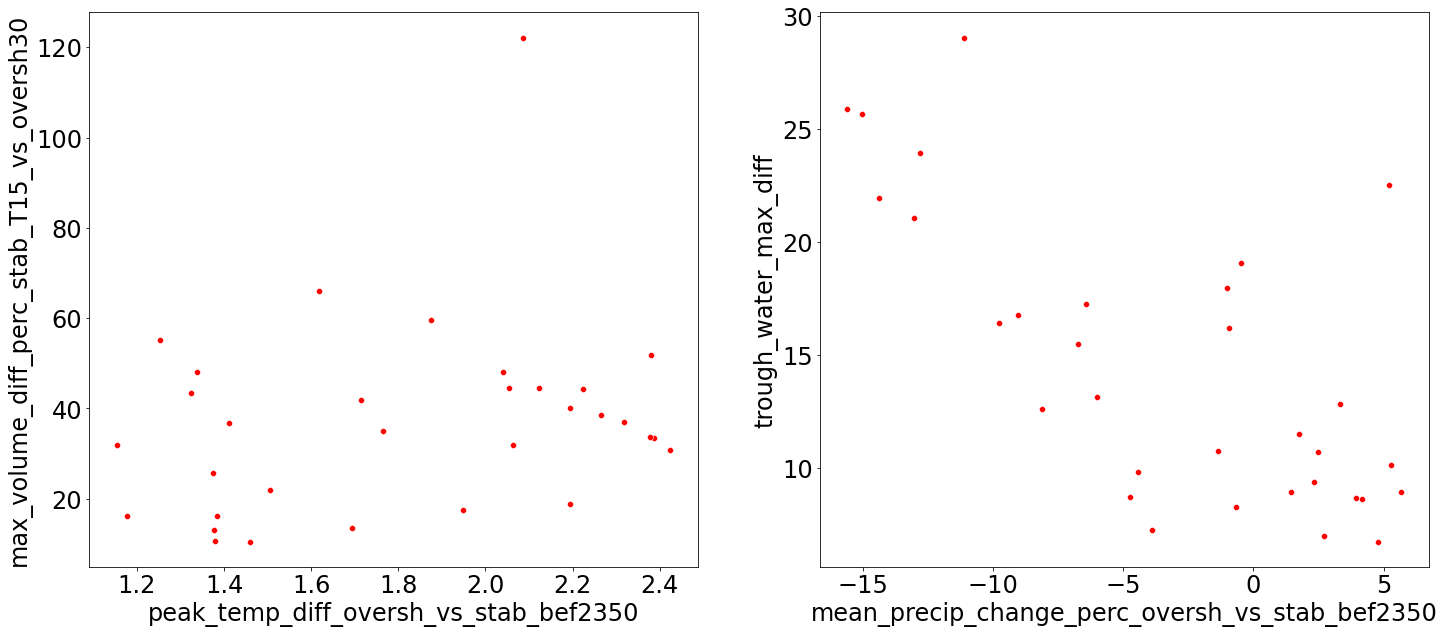

In [67]:
plt.figure(figsize=(24,10))
plt.subplot(121)
#no relation ... 
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_trough).dropna(),
                y='max_volume_diff_perc_stab_T15_vs_oversh30',
                x='peak_temp_diff_oversh_vs_stab_bef2350',
                color='red') 
plt.subplot(122)
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_trough).dropna(),
                y='trough_water_max_diff',
                x='mean_precip_change_perc_oversh_vs_stab_bef2350',
                color='red') #, 
#label=f'{n} basins  with >1% avg. precipitation decrease\nin period 2050-2350 f
#or Overshoot 3.0°C->1.5°C\ncompared to 1.5°C stabilisation scenario') 

#, label=f'{n} basins  with >1% avg. precipitation decrease\nin period 2050-2350 for Overshoot 3.0°C->1.5°C\ncompared to 1.5°C stabilisation scenario') 

In [68]:
water_trough_stats_basins_sel.where(condi_vol_diff & condi_prcp_increase).dropna().trough_water_max_diff.median()

9.138313293457031

In [69]:
water_trough_stats_basins_sel.where(condi_vol_diff & condi_prcp_decrease).dropna().trough_water_max_diff.median()

16.772171020507812

In [70]:
water_trough_stats_basins_sel.where(condi_vol_diff & condi_prcp_decrease).dropna().trough_water_max_diff.median() / water_trough_stats_basins_sel.where(condi_vol_diff & condi_prcp_increase).dropna().trough_water_max_diff.median()

1.8353683532076506

In [71]:
water_trough_stats_basins_sel.where(condi_vol_diff & condi_prcp_decrease).dropna().trough_water_max_diff.median() / water_trough_stats_basins_sel.where(condi_vol_diff & condi_prcp_increase).dropna().trough_water_max_diff.median()

1.8353683532076506

In [72]:
water_trough_stats_basins_sel['cumulative_runoff_diff_trough'] = water_trough_stats_basins_sel.cumulative_runoff_diff_trough.astype(float)
water_trough_stats_basins_sel['yrs_with_trough_water'] = water_trough_stats_basins_sel.yrs_with_trough_water.astype(float)
water_trough_stats_basins_sel.where(condi_vol_diff & condi_prcp_decrease).dropna().cumulative_runoff_diff_trough.median() / water_trough_stats_basins_sel.where(condi_vol_diff & condi_prcp_increase).dropna().cumulative_runoff_diff_trough.median()

3.9830082986557813

**The water trough maximum is around 2 times larger for basins where precipitation decreases for warmer temperatures and the cumulative runoff difference is 4 times larger ...** 

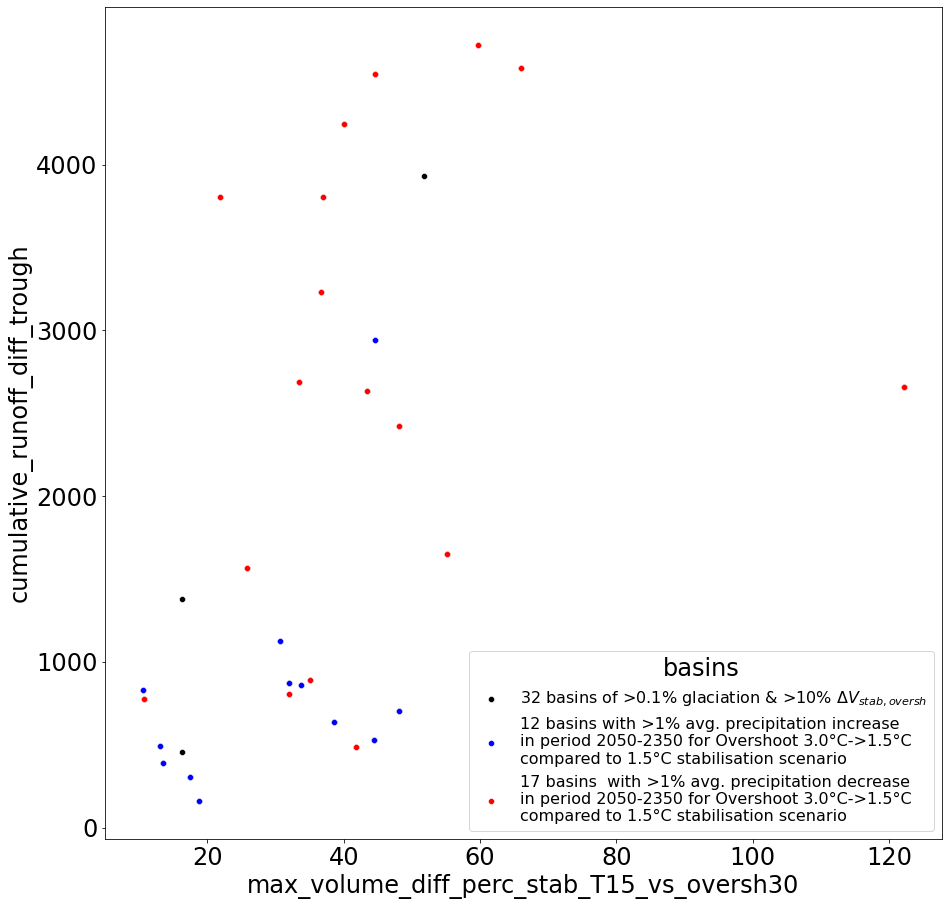

In [73]:
plt.figure(figsize=(15,15))
n=len(water_trough_stats_basins_sel.where(condi_vol_diff).dropna())
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_vol_diff).dropna(),
                y='cumulative_runoff_diff_trough',
                x='max_volume_diff_perc_stab_T15_vs_oversh30', color='black',
                label=f'{n} basins of >0.1% glaciation & >10%'+r' $\Delta V_{stab,oversh}$') #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)

n=len(water_trough_stats_basins_sel.where(condi_vol_diff & condi_prcp_increase).dropna())
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_vol_diff & condi_prcp_increase).dropna(),
                y='cumulative_runoff_diff_trough',
                x='max_volume_diff_perc_stab_T15_vs_oversh30', color='blue',
                label=f'{n} basins with >1% avg. precipitation increase\nin period 2050-2350 for Overshoot 3.0°C->1.5°C\ncompared to 1.5°C stabilisation scenario')  #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)

n=len(water_trough_stats_basins_sel.where(condi_vol_diff & condi_prcp_decrease).dropna())
sns.scatterplot(data = water_trough_stats_basins_sel.where(condi_vol_diff & condi_prcp_decrease).dropna(),
                y='cumulative_runoff_diff_trough',
                x='max_volume_diff_perc_stab_T15_vs_oversh30',
                color='red', label=f'{n} basins  with >1% avg. precipitation decrease\nin period 2050-2350 for Overshoot 3.0°C->1.5°C\ncompared to 1.5°C stabilisation scenario') 
#, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax

plt.legend(title='basins', fontsize=16)

## Selected three driest consecutive months

The three-month period precipitation seasonality was computed by three-month rolling average basin precipitation which is then for each month averaged over the 30-year period. Subsequently, the six-month period with the highest melt within a year was estimated from the glacier simulations, during which the driest three-month period was selected. 

In [74]:
#**I was confused why I get negative values out of a rollling sum of positive values ...**
# the issue was numerical instabiliity of rolling.sum or rolling.mean ... : https://github.com/pydata/xarray/issues/7128
xr.set_options(use_bottleneck=False)

In [75]:
#www_lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/analysis_notebooks/schuster_el_al_phd_paper_2_overshoot_glaciers/1x_extract_RGIregion_basin_drymonths.ipynb
basin_stats_driest = pd.read_csv('../data/additional_data/basin_driest_months.csv')

def func_sel_months(basin_id, opt = 'last_3m_driest_month_seasonal_avg'):
    _sel = basin_stats_driest.loc[basin_stats_driest.MRBID==int(basin_id)]
    last_month_of_3m_driest = int(_sel[opt].values)
    return last_month_of_3m_driest
    #basin_stats_driest

df_scenario_common_basins_runoff_drymonths = df_scenario_common_basin[['runoff_monthly','melt_off_on_monthly']].copy()
df_scenario_common_basins_runoff_drymonths.coords['year'] = df_scenario_common_basins_runoff_drymonths.coords['time'].astype(int)
df_scenario_common_basins_runoff_drymonths.coords['month'] = df_scenario_common_basins_runoff_drymonths.month_2d
df_scenario_common_basins_runoff_drymonths = df_scenario_common_basins_runoff_drymonths.stack(year_month = ("time","month_2d"))
df_scenario_common_basins_runoff_drymonths['year_month'] = df_scenario_common_basins_runoff_drymonths.year + (df_scenario_common_basins_runoff_drymonths.month-1)/12
assert np.all(df_scenario_common_basins_runoff_drymonths['runoff_monthly'].min()>=0)
# Check for negative values in the 'runoff_monthly' DataArray
no_negative_values = df_scenario_common_basins_runoff_drymonths['runoff_monthly'] >= 0
assert no_negative_values.all()

df_scenario_common_basins_runoff_drymonths['runoff_monthly'] = df_scenario_common_basins_runoff_drymonths['runoff_monthly'].rolling(year_month=3, #center=True,
                             min_periods=3).mean()
df_scenario_common_basins_runoff_drymonths['melt_off_on_monthly'] = df_scenario_common_basins_runoff_drymonths['melt_off_on_monthly'].rolling(year_month=3,
                                                                                                                                              min_periods=3).mean()
assert np.all(df_scenario_common_basins_runoff_drymonths['runoff_monthly'].min()>=0)
assert np.all(df_scenario_common_basins_runoff_drymonths['melt_off_on_monthly'].min()>=0)

df_scenario_common_basins_runoff_drymonths['runoff_monthly'] = df_scenario_common_basins_runoff_drymonths['runoff_monthly'].dropna(dim='year_month')
df_scenario_common_basins_runoff_drymonths['melt_off_on_monthly'] = df_scenario_common_basins_runoff_drymonths['melt_off_on_monthly'].dropna(dim='year_month')

assert df_scenario_common_basins_runoff_drymonths.runoff_monthly.dropna(dim='year_month').year_month[0].values == 2000 + (3-1)/12 # just t make sure that the month corresponds to the last month ... 
assert df_scenario_common_basins_runoff_drymonths.melt_off_on_monthly.dropna(dim='year_month').year_month[0].values == 2000 + (3-1)/12 # just t make sure that the month corresponds to the last month ... 



In [76]:
# volume should be basically the same between scenario in first 20 years (as all use W5E5)
assert (df_scenario_common_basin.sel(time=slice(2000,2020)).volume.std(dim='scenario')/df_scenario_common_basin.sel(time=slice(2000,2020)).volume.mean(dim='scenario')).max() <0.01

_sel = df_scenario_common_basins_runoff_drymonths.melt_off_on_monthly.sel(year_month=slice(2000 + 2/12,2020 + 1/12))#.sel(scenario=scenarios)
# we do the average over the scenarios as each scenario is abit different due to the last year (2020)
assert len(_sel.year_month)/12 == 20
past_seasonal_avg_melt_off_on_monthly_3mavg_last = _sel.groupby('month').mean()
# todo: that one does not work
#assert np.all(past_seasonal_avg_melt_off_on_monthly_3mavg_last.std(dim='scenario')/past_seasonal_avg_melt_off_on_monthly_3mavg_last.mean(dim='scenario')<1e-2)
basin_strange = (past_seasonal_avg_melt_off_on_monthly_3mavg_last.std(dim='scenario')/past_seasonal_avg_melt_off_on_monthly_3mavg_last.mean(dim='scenario')).max(dim='month').argmax()
print((past_seasonal_avg_melt_off_on_monthly_3mavg_last.std(dim='scenario')/past_seasonal_avg_melt_off_on_monthly_3mavg_last.mean(dim='scenario')).max(dim='month').max().values)
basin_id = past_seasonal_avg_melt_off_on_monthly_3mavg_last.isel(basin=basin_strange).basin.values
print(basin_id)
basin_name = pd_basin_num.loc[pd_basin_num.MRBID == int(basin_id)]['RIVER_BASI'].values
print(basin_name)
# without that basin it coincides better
_drop_strange = past_seasonal_avg_melt_off_on_monthly_3mavg_last.drop_isel(basin=basin_strange)
# 
assert (_drop_strange.std(dim='scenario')/_drop_strange.mean(dim='scenario')).max() < 0.011
# ok as it is basically the same between the scenarios (from 2000-2019 this has to be of course)
past_seasonal_avg_melt_off_on_monthly_3mavg_last = past_seasonal_avg_melt_off_on_monthly_3mavg_last.mean(dim='scenario')

0.043979406096395085
3403
['AZOPARDO']


In [77]:
# find the median 
median_past_seasonal_avg_melt_off_on_monthly_3mavg_last = past_seasonal_avg_melt_off_on_monthly_3mavg_last.median(dim='month')
# now, just take those months of every basin where melt is equal or above the median
pd_months_w_melt_above_eq_median = past_seasonal_avg_melt_off_on_monthly_3mavg_last.where(past_seasonal_avg_melt_off_on_monthly_3mavg_last>=median_past_seasonal_avg_melt_off_on_monthly_3mavg_last).to_dataframe().reset_index()
pd_months_w_melt_above_eq_median = pd_months_w_melt_above_eq_median.dropna()
assert len(pd_months_w_melt_above_eq_median)/75 == 6
pd_months_w_melt_above_eq_median = pd_months_w_melt_above_eq_median.reset_index(drop=True)

### get the 
pd_pr_seasonality_basin =pd.read_csv('../data/additional_data/basin_past_pr_seasonality_3m_roll_lastm.csv', index_col=0)
for r in pd_months_w_melt_above_eq_median.index:
    _r = pd_months_w_melt_above_eq_median.loc[r].copy()
    basin = _r['basin']
    month = _r['month']
    pd_months_w_melt_above_eq_median.loc[r,'pr_3m_sum'] = pd_pr_seasonality_basin.loc[(pd_pr_seasonality_basin.month==month)&(pd_pr_seasonality_basin.basin==int(basin))]['pr_3m_sum'].values.squeeze()
ds_months_w_melt_above_eq_median_pr = pd_months_w_melt_above_eq_median[['basin','month', 'pr_3m_sum']].groupby(['basin','month']).mean().to_xarray()
#['pr_3m_sum']


In [78]:
basin_stats_driest.index = basin_stats_driest['MRBID'].values.astype(str)
pd_months_w_melt_above_eq_median_pr = ds_months_w_melt_above_eq_median_pr.idxmin(dim='month').to_dataframe()
basin_stats_driest.loc[pd_months_w_melt_above_eq_median_pr.index,'last_3m_driest_month_seasonal_avg_within_melt_months'] = pd_months_w_melt_above_eq_median_pr['pr_3m_sum']

In [79]:
basins = pd_basins_arid_glac_num.MRBID.values

In [80]:
basin_stats_driest.loc[basins.astype(str)][['MRBID','RIVER_BASI','last_3m_driest_month_seasonal_avg','last_3m_driest_month_seasonal_avg_within_melt_months']]

MRBID                 RIVER_BASI  last_3m_driest_month_seasonal_avg  \
2309   2309                      INDUS                               12.0   
3425   3425                      SANTA                                8.0   
2919   2919  YSYK-KOL (also ISSYK-KUL)                                2.0   
3423   3423                      RAPEL                                3.0   
2914   2914  TARIM HE (also TALIMU HE)                                1.0   
6243   6243                      RHONE                                8.0   
2902   2902                   ARAL SEA                                9.0   

      last_3m_driest_month_seasonal_avg_within_melt_months  
2309                                               11.0     
3425                                               10.0     
2919                                               11.0     
3423                                                3.0     
2914                                               11.0     
6243                                                8.0     
2902                                                9.0

/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='last_3m_driest_month_seasonal_avg_within_melt_months', ylabel='CONTINENT'>

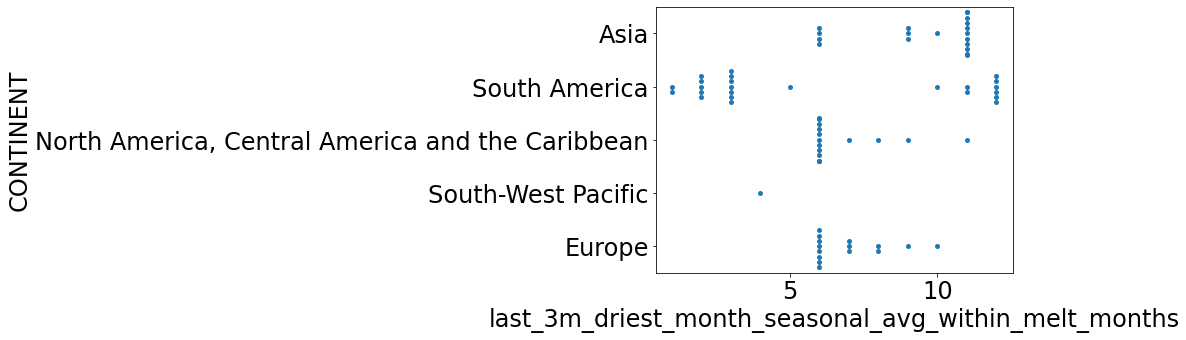

In [81]:
sns.swarmplot(data=basin_stats_driest, y='CONTINENT', x= 'last_3m_driest_month_seasonal_avg_within_melt_months')#, cut=0)

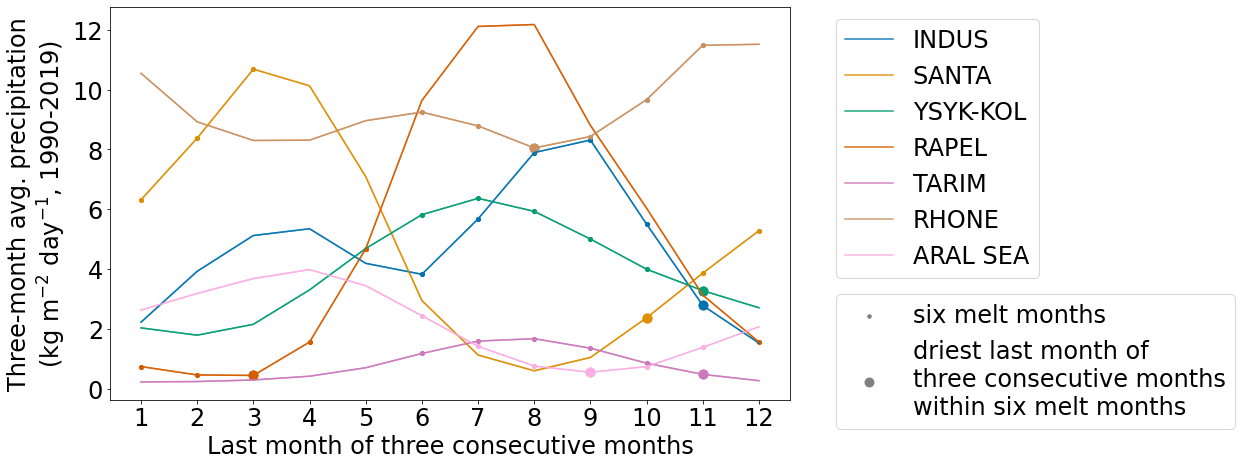

In [82]:
col_basins = sns.color_palette('colorblind')
plt.figure(figsize=(18,7))
for j,basin in enumerate(['INDUS', 'SANTA', 'YSYK-KOL (also ISSYK-KUL)', 'RAPEL',
              'TARIM HE (also TALIMU HE)', 'RHONE', 'ARAL SEA']):
    basin_id=pd_basin_num.loc[pd_basin_num.RIVER_BASI==basin]['MRBID'].values[0]
    basin_avg_pr_seasonal_sel = pd_pr_seasonality_basin.loc[pd_pr_seasonality_basin.basin==basin_id]
    if basin=='TARIM HE (also TALIMU HE)':
        basin = 'TARIM' # HE\n(also TALIMU HE)'
    elif basin =='YSYK-KOL (also ISSYK-KUL)':
        basin = 'YSYK-KOL'
    plt.plot(basin_avg_pr_seasonal_sel.month,
             basin_avg_pr_seasonal_sel.pr_3m_sum,
            label=basin, alpha = 0.9,ls='-', color=col_basins[j]) # TARIM HE
    #plt.title(basin)
    plt.scatter(pd_months_w_melt_above_eq_median.loc[pd_months_w_melt_above_eq_median.basin==str(basin_id)].month,
             pd_months_w_melt_above_eq_median.loc[pd_months_w_melt_above_eq_median.basin==str(basin_id)].pr_3m_sum,
             #label=basin, 
                marker='.', s=50, color=col_basins[j], label='six melt months') # TARIM HE
    m_sel = basin_stats_driest.loc[basin_stats_driest.MRBID==basin_id,'last_3m_driest_month_seasonal_avg_within_melt_months'].values.squeeze()
    plt.scatter(m_sel,basin_avg_pr_seasonal_sel.loc[basin_avg_pr_seasonal_sel.month==m_sel,'pr_3m_sum'],
               marker='o', s=80,color=col_basins[j], label='driest last month of\nthree consecutive months\nwithin six melt months')
    plt.xlabel('Last month of three consecutive months')
    plt.ylabel('Three-month avg. precipitation\n'+r'(kg m$^{-2}$ day$^{-1}$, 1990-2019)')
    pd_months_w_melt_above_eq_median
    plt.xticks(np.arange(1,12.1,1))
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
handles_w = handles.copy()
leg = plt.legend(handles_w[::3], labels[::3], ncol=1, loc = 'upper left', bbox_to_anchor=(1.05,1))
for h in handles_w[1:3]:
    h.set_color('grey')
plt.legend(handles_w[1:3], labels[1:3],loc = 'upper left', bbox_to_anchor=(1.05,0.3))

### strange grey dots in legend
for j,basin in enumerate(['INDUS', 'SANTA', 'YSYK-KOL (also ISSYK-KUL)', 'RAPEL',
              'TARIM HE (also TALIMU HE)', 'RHONE', 'ARAL SEA']):
    basin_id=pd_basin_num.loc[pd_basin_num.RIVER_BASI==basin]['MRBID'].values[0]
    basin_avg_pr_seasonal_sel = pd_pr_seasonality_basin.loc[pd_pr_seasonality_basin.basin==basin_id]

    plt.plot(basin_avg_pr_seasonal_sel.month,
             basin_avg_pr_seasonal_sel.pr_3m_sum,
            label=basin, alpha = 0.7,ls='-', color=col_basins[j]) # TARIM HE
    #plt.title(basin)
    plt.scatter(pd_months_w_melt_above_eq_median.loc[pd_months_w_melt_above_eq_median.basin==str(basin_id)].month,
             pd_months_w_melt_above_eq_median.loc[pd_months_w_melt_above_eq_median.basin==str(basin_id)].pr_3m_sum,
             #label=basin, 
                marker='.', s=70, color=col_basins[j], label='six melt months') # TARIM HE
    m_sel = basin_stats_driest.loc[basin_stats_driest.MRBID==basin_id,'last_3m_driest_month_seasonal_avg_within_melt_months'].values.squeeze()
    plt.scatter(m_sel,basin_avg_pr_seasonal_sel.loc[basin_avg_pr_seasonal_sel.month==m_sel,'pr_3m_sum'],
               marker='o', s=80,color=col_basins[j], label='driest last month of\nthree consecutive months\nwithin six melt months')
    plt.xlabel('Last month of three consecutive months')
    plt.ylabel('Three-month avg. precipitation\n'+r'(kg m$^{-2}$ day$^{-1}$, 1990-2019)')
    pd_months_w_melt_above_eq_median
    plt.xticks(np.arange(1,12.1,1))

ax.add_artist(leg)
plt.tight_layout()
plt.savefig('../figures/3_suppl_fig_precipitation_cycle_selected_basins.png')

- could also put here as xaxis NDJ, DJF, ... 

In [83]:
#### only for monthly runoff ...
opt = 'last_3m_driest_month_seasonal_avg_within_melt_months'
#opt = 'last_3m_driest_month_seasonal_avg' ## this was the old option looking at all months

#### only for monthly runoff ...
df_scenario_common_basins_dry_m_runoff_l = []
for basin_id in df_scenario_common_basin.basin:
    sel_month = func_sel_months(basin_id, opt=opt)
    sel_yr_month = df_scenario_common_basins_runoff_drymonths.year_month.where(df_scenario_common_basins_runoff_drymonths.month==sel_month).dropna(dim='year_month')
    _df_scenario_common_basins_dry_m_runoff = df_scenario_common_basins_runoff_drymonths.sel(basin=basin_id).sel(year_month=sel_yr_month)
    _df_scenario_common_basins_dry_m_runoff.coords['last_month_of_three_driest_months'] = str(sel_month)
    _df_scenario_common_basins_dry_m_runoff = _df_scenario_common_basins_dry_m_runoff.swap_dims({'year_month':'year'}).reset_coords()
    df_scenario_common_basins_dry_m_runoff_l.append(_df_scenario_common_basins_dry_m_runoff)
df_scenario_common_basins_dry_m_runoff = xr.concat(df_scenario_common_basins_dry_m_runoff_l, dim='basin')
df_scenario_common_basins_dry_m_runoff['runoff_monthly_51_yr_avg'] = df_scenario_common_basins_dry_m_runoff.runoff_monthly.isel(year=slice(0,-1)).rolling(min_periods=51, #50 
                                                                                                                                                          year=51, center=True).mean()
pd_runoff_dry3m_scenario_rel_basin = (100*df_scenario_common_basins_dry_m_runoff.runoff_monthly_51_yr_avg/df_scenario_common_basins_dry_m_runoff.sel(year=2025).runoff_monthly_51_yr_avg).to_dataframe('runoff_dry3m_rel_2000_2050_%').reset_index()
# in the other plots year was always time, so easier to have it here as well:
pd_runoff_dry3m_scenario_rel_basin['time'] = pd_runoff_dry3m_scenario_rel_basin['year']

pd_runoff_dry3m_scenario_rel_basin['stab_vs_oversh'] = 'oversh'
pd_runoff_dry3m_scenario_rel_basin.loc[pd_runoff_dry3m_scenario_rel_basin['scenario'].apply(lambda x: 'stab' in x).values, 'stab_vs_oversh'] = 'stab'


In [84]:
# Definition:
# “Trough water” occurs if the 51-year average annual runoff from the 
# “Overshoot 3.0°C -> 1.5°C” scenario is at least 5\% smaller than (i) in the “Stabilisation 1.5°C” scenario for 20 years 
# and  (ii) than in the baseline period 
# (initial steady state for the idealised experiments, 2000--2020 or 2000--2050 climate for the projections with the ESM).
### --> the second condition just means it has to be smaller than or equal to 95% 
runoff_var = 'runoff_dry3m_rel_2000_2050_%'
water_trough_stats_basins_3m_driest = pd.DataFrame(index = pd_runoff_dry3m_scenario_rel_basin.basin.unique(),
                                  columns= ['yrs_with_trough_water',  'cumulative_runoff_diff_trough', 
                                            'trough_water_min_year', 'trough_water_max_diff',
                                            'trough_water_pot_start_end'])
for basin in pd_runoff_dry3m_scenario_rel_basin.basin.unique():
    pd_runoff_scenario_rel_basin_sel = pd_runoff_dry3m_scenario_rel_basin.loc[pd_runoff_dry3m_scenario_rel_basin.basin==basin]
    # overshoot runoff smaller than 0.95 times stabilisation runoff (both use 501r avg. runoff)
    sel_oversh = pd_runoff_scenario_rel_basin_sel.loc[pd_runoff_scenario_rel_basin_sel.scenario=='oversh_T30OS15']
    sel_stab = pd_runoff_scenario_rel_basin_sel.loc[pd_runoff_scenario_rel_basin_sel.scenario=='stab_T15']
    _output = get_basin_trough_water_stats(sel_stab, sel_oversh, 
                                 runoff_var = runoff_var)
    water_trough_stats_basins_3m_driest.loc[basin] = _output

In [85]:
water_trough_stats_basins_3m_driest_c = water_trough_stats_basins_3m_driest.copy()


Text(0.5, 1.0, 'TARIM HE (also TALIMU HE) 2914 - last month of 3m driest period in melt season: 11')

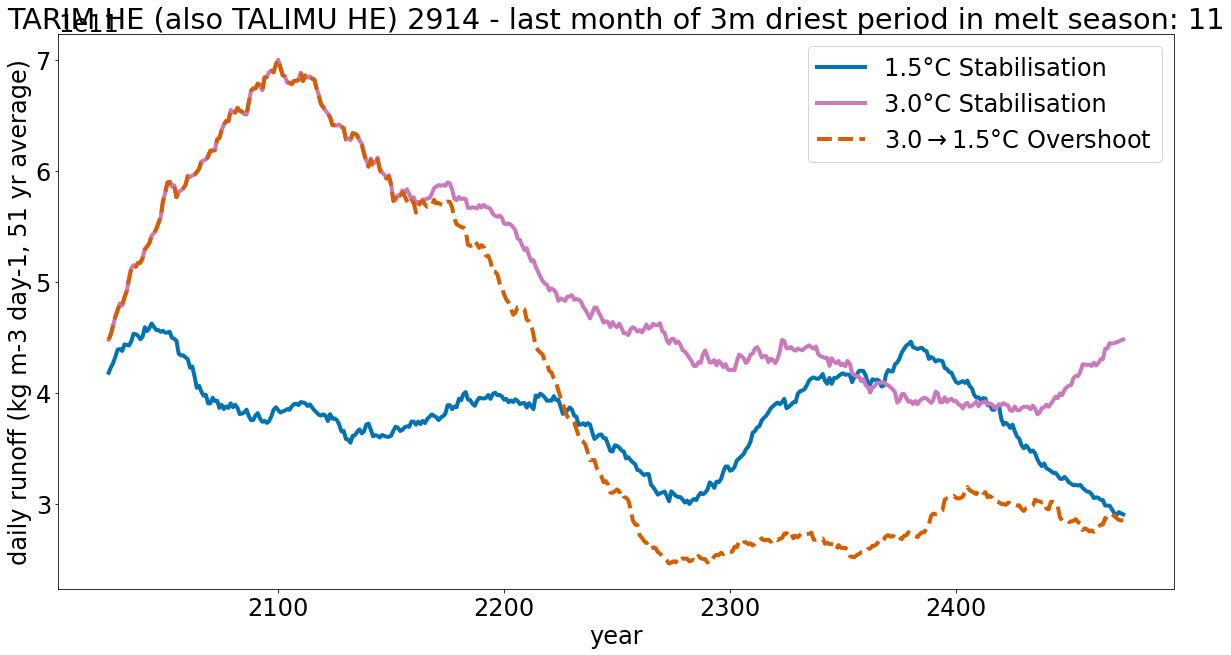

In [86]:
basins = pd_basins_arid_glac_num.MRBID.values

plt.figure(figsize=(20,10))
name = basin_stats_driest.loc[basin_stats_driest.MRBID==int(basins[4])]['RIVER_BASI'].values[0]
last_month_of3mdriest = int(basin_stats_driest.loc[basin_stats_driest.MRBID==int(basins[4])][opt].values[0])
for scenario in scenarios:
    _s = df_scenario_common_basins_dry_m_runoff.sel(basin=str(basins[4])).sel(scenario=scenario)
    sns.lineplot(data=_s.to_dataframe().reset_index(),
                x='year', y='runoff_monthly_51_yr_avg', lw=4,
                 ls = scenario_ls[scenario],
                color = color_scenario[scenario], label=label_scenario[scenario])
plt.ylabel('daily runoff (kg m-3 day-1, 51 yr average)')
plt.title(f'{name} {basins[4]} - last month of 3m driest period in melt season: {last_month_of3mdriest}')

In [87]:
sel_month_to_name_dict={}
months_n = 'NDJFMAMJJASOND'
ms = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
for j in np.arange(0,12,1):
    sel_month_to_name_dict[ms[j]+1] = months_n[ms[j]] + months_n[ms[j+1]] + months_n[ms[j+2]]


In [88]:
basin_stats_driest_c = basin_stats_driest.copy()
basin_stats_driest_c = basin_stats_driest_c.set_index('RIVER_BASI')

water_trough_stats_basins_3m_driest_c.index = water_trough_stats_basins_3m_driest_c.index.astype(int)
water_trough_stats_basins_3m_driest_c = water_trough_stats_basins_3m_driest_c.loc[basin_stats_driest_c.loc[pd_basins_arid_glac_num.index].MRBID]
water_trough_stats_basins_3m_driest_c['RIVER_BASI'] = pd_basins_arid_glac_num.index
water_trough_stats_basins_3m_driest_c = water_trough_stats_basins_3m_driest_c.set_index('RIVER_BASI')


pd_basins_arid_glac_num_all = pd.concat([pd_basins_arid_glac_num, water_trough_stats_basins_3m_driest_c,
                                         basin_stats_driest_c.loc[pd_basins_arid_glac_num.index,['last_3m_driest_month_seasonal_avg',
       'last_3m_driest_most_frequent_month',
       'perc_yrs_w_last_3m_driest_most_frequent_month',
       'last_3m_driest_month_seasonal_avg_within_melt_months']]], axis=1)
pd_basins_arid_glac_num_all.to_csv('../data/additional_data/seven_arid_basins_all_stats.csv')
pd_runoff_dry3m_scenario_rel_basin.to_csv('../data/additional_data/seven_arid_basins_runoff_2000_2500_timeseries.csv')

**--> final updated fig. 4 plot is done here: [3b_fig_4.ipynb](3b_fig_4.ipynb)**

**Some stats for the dry melt season runoff stuff**

In [89]:
water_trough_stats_basins_3m_driest_sel = water_trough_stats_basins_3m_driest.loc[basin_glac_ind].copy() #
water_trough_stats_basins_3m_driest_sel['trough_water_max_diff_no_NaNs'] = water_trough_stats_basins_3m_driest_sel['trough_water_max_diff'].copy()
water_trough_stats_basins_3m_driest_sel['yrs_with_trough_water_no_NaNs'] = water_trough_stats_basins_3m_driest_sel['yrs_with_trough_water'].copy()

water_trough_stats_basins_3m_driest_sel['cumulative_runoff_diff_trough_no_NaNs'] = water_trough_stats_basins_3m_driest_sel['cumulative_runoff_diff_trough'].astype(float)
water_trough_stats_basins_3m_driest_sel.loc[water_trough_stats_basins_3m_driest_sel.trough_water_max_diff_no_NaNs.isna(),'trough_water_max_diff_no_NaNs'] = 0
water_trough_stats_basins_3m_driest_sel.loc[water_trough_stats_basins_3m_driest_sel.yrs_with_trough_water_no_NaNs.isna(),'yrs_with_trough_water_no_NaNs'] = 0

water_trough_stats_basins_3m_driest_sel.loc[water_trough_stats_basins_3m_driest_sel.cumulative_runoff_diff_trough_no_NaNs.isna(),'cumulative_runoff_diff_trough_no_NaNs'] = 0


In [90]:
print(len(water_trough_stats_basins_sel.where(water_trough_stats_basins_sel['trough_water_max_diff'].astype(float)>0).dropna(how='all')))

32


In [91]:
condi_water_trough_dry_melt_season = water_trough_stats_basins_3m_driest_sel['trough_water_max_diff'].astype(float)>0
condi_water_trough_dry_melt_season
### basins 0.1% glaciated, that get an at least 10% larger glacier volume and create a trough water after the year 2170: 
print(len(water_trough_stats_basins_3m_driest_sel.where(condi_water_trough_dry_melt_season).dropna(how='all')))
print(len(water_trough_stats_basins_3m_driest_sel.where(condi_water_trough_dry_melt_season& condi_vol_diff).dropna(how='all')))

### basins 0.1% glaciated, that get an at least 10% larger glacier volume after the global overshoot (i.e., after the year 2150) and create a trough water after the year 2150:
print(len(water_trough_stats_basins_3m_driest_sel.where(condi_water_trough_dry_melt_season& condi_vol_diff& condi_after_2150).dropna(how='all')))

32
32
26


In [92]:
# check if water trough is always after 2150 
assert float(water_trough_stats_basins_3m_driest_sel.where(condi_water_trough_dry_melt_season).dropna(how='all')['trough_water_min_year'].min()) >= 2150 

**From here on it gets unsorted and potentially old**

In [86]:
# this is the same, so we can just copy it
water_trough_stats_basins_3m_driest_sel.loc[water_trough_stats_basins_sel.index,'max_volume_diff_perc_stab_T15_vs_oversh30'] = water_trough_stats_basins_sel.max_volume_diff_perc_stab_T15_vs_oversh30.astype(float)

<AxesSubplot:xlabel='max_volume_diff_perc_stab_T15_vs_oversh30', ylabel='trough_water_max_diff_no_NaNs'>

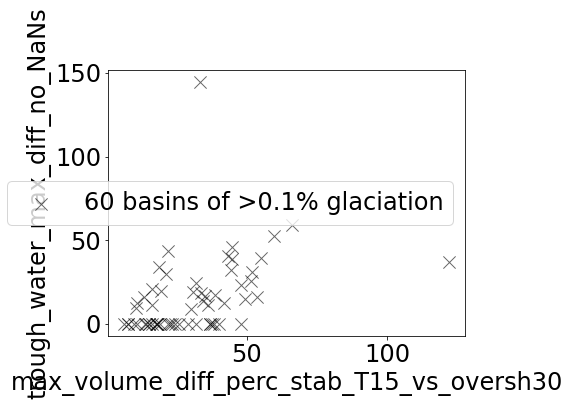

In [87]:
n = len(water_trough_stats_basins_3m_driest_sel.dropna(how='all'))
sns.scatterplot(data = water_trough_stats_basins_3m_driest_sel[['trough_water_max_diff_no_NaNs','max_volume_diff_perc_stab_T15_vs_oversh30']].dropna().astype(float), #.where(condi_trough).dropna(),
                y='trough_water_max_diff_no_NaNs',
                x='max_volume_diff_perc_stab_T15_vs_oversh30', color='black', 
                alpha = 0.6, marker='x', s= 150,
                label=f'{n} basins of >0.1% glaciation') #, hue='mean_precip_change_perc_oversh_vs_stab_bef_vs_aft2350') #, ax=ax)